In [1]:
import os
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import statsapi
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')


import pybaseball

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix, precision_score, plot_roc_curve
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier


import xgboost as xgb

import category_encoders as ce

from dateutil import tz

from time import sleep

import pickle

In [ ]:
def statcast_importer(year = datetime.now().year):
    start = datetime(year, 1, 1)
    if year == datetime.now().year:
        end = datetime.now()-timedelta(weeks=1)
    else:
        end = datetime(year,12, 31)
    df = pybaseball.statcast(str(start.year) + '-' + '{:0>2}'.format(str(start.month)) + '-' + '{:0>2}'.format(str(start.day)), str(end.year) + '-' + '{:0>2}'.format(str(end.month)) + '-' + '{:0>2}'.format(str(end.day)))
    df.to_csv('untouched_' + str(year) + '_statcast_pbp.csv')

    num_columns = ['release_speed', 'batter', 'pitcher', 'zone', 'hit_location', 'balls', 'strikes', 'game_year', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'fielder_2', 'hit_distance_sc', 'release_spin_rate', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'woba_value', 'woba_denom', 'babip_value', 'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score']

    num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median'))
    ])
    preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_columns)])
    clf = Pipeline(steps=[('preprocessor', preprocessor)])

    t = clf.fit_transform(df)

    df[num_columns] = t

#   drop spring training, playoff games

    df = df[df['game_type'] == 'R']
    print('Non-regular season games dropped')


    df.to_csv(str(year)+'_statcast_pbp.csv')
    return(df)

In [ ]:
# establish definitions for the events column for what ends a plate appearance ending event and a hit
# the statcast includes data for every pitch which needs to be pared down to determine whether a player got a hit
pa_ending_events = np.array(['field_out',
                        'strikeout',
                        'single',
                        'walk',
                        'double',
                        'home_run',
                        'force_out',
                        'grounded_into_double_play',
                        'hit_by_pitch',
                        'field_error',
                        'sac_fly',
                        'triple',
                        'sac_bunt',
                        'fielders_choice',
                        'double_play',
                        'fielders_choice_out',
                        'strikeout_double_play',
                        'catcher_interf',
                        'sac_fly_double_play',
                        'triple_play',
                        'sac_bunt_double_play'])


hit_events = np.array(['single',
            'double',
            'home_run',
            'triple'])

american_league_teams = np.array(['Boston Red Sox', 'Houston Astros', 'Chicago White Sox', 'Tampa Bay Rays', 'Oakland Athletics', 'Seattle Mariners', 'New York Yankees', 'Toronto Blue Jays', 'Los Angeles Angels', 'Cleveland Indians', 'Detroit Tigers', 'Kansas City Royals', 'Minnesota Twins', 'Texas Rangers', 'Baltimore Orioles'])


num_columns = ['release_speed', 'derive_batter', 'derive_pitcher', 'zone', 'hit_location', 'balls', 'strikes', 'game_year', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'fielder_2', 'hit_distance_sc', 'release_spin_rate', 'game_pk', 'derive_pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'woba_value', 'woba_denom', 'babip_value', 'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score']

column_types = [np.int8,
np.int32,
np.int32,
np.int8,
np.int8,
np.int8,
np.int8,
np.int16,
np.int32,
np.int32,
np.int32,
np.int32,
np.int32,
np.int32,
np.int16,
np.int16,
np.int32,
np.int16,
np.int16,
np.int16,
np.int16,
np.int16,
np.int16,
np.int16,
np.int16,
np.int16,
np.int8,
np.int8,
np.int8,
np.uint8,
np.uint8,
np.uint8,
np.uint8,
np.uint8,
np.uint8,
np.uint8,
np.uint8,
np.uint8,
np.uint8]

type_dict = dict(zip(num_columns, column_types))

In [ ]:
def set_types(df, type_dict):
    '''Explicitly names datatypes in order to speed up preprocessing of a large dataset'''

    df['game_date'] = pd.to_datetime(df['game_date'], format='%Y-%m-%d')
    print('datetime done')
    df['events'] = df['events'].apply(lambda x: 1 if x in hit_events else (0 if x in pa_ending_events else -1)).astype(np.int8)
    print('events done')
    df['batter_righty'] = df['stand'].apply(lambda x: 1 if x == 'R' else 0).astype(np.int8)
    print('stand done')
    df['pitcher_righty'] = df['p_throws'].apply(lambda x: 1 if x == 'R' else 0).astype(np.int8)
    print('derive_pitcher done')
    df['home'] = df['inning_topbot'].apply(lambda x: 1 if x == 'Bot' else 0).astype(np.int8)
    print('inning done')

    for key, value in type_dict.items():
        df[key] = df[key].astype(value)

    df = df.select_dtypes(exclude=['object'])
    for col in df.columns:
        if col.startswith('Unnamed:'):
            df = df.drop([col], axis=1)
    return (df)

In [8]:
def convert_UTC_to_local(row):
    """Takes in a row containing a baseball game's location and UTC start time"""

    #     Reads in latitude, longitude, and altitude for known venues
    venue_coords = pd.read_csv('Parks.csv')

    venue_name = row['venue_name']
    game_datetime = row['game_datetime']

    #     get timezone object for UTC
    from_zone = tz.gettz('UTC')

    try:
        city = venue_coords[venue_coords['NAME'] == row['venue_name']]['CITY'].iloc[0]
        lat = venue_coords[venue_coords['NAME'] == row['venue_name']]['Latitude'].iloc[0]
        lon = venue_coords[venue_coords['NAME'] == row['venue_name']]['Longitude'].iloc[0]
        alt = venue_coords[venue_coords['NAME'] == row['venue_name']]['Altitude'].iloc[0]
    except NameError:
        #         Need to add new venue to Parks.csv
        raise IndexError(venue, index)
    if city == 'Tokyo':
        to_zone = tz.gettz('Asia/Tokyo')
    elif city == 'London':
        to_zone = tz.gettz('Europe/London')
    elif city in ['San Francisco',
                  'Oakland',
                  'Phoenix',
                  'Seattle',
                  'Los Angeles',
                  'San Diego',
                  'Anaheim']:
        to_zone = tz.gettz('America/Los_Angeles')
    elif city == 'Denver':
        to_zone = tz.gettz('America/Denver')
    elif city in ['Minneapolis',
                  'Milwaukee',
                  'Chicago',
                  'St. Louis',
                  'Arlington',
                  'Kansas City',
                  'Houston',
                  'Monterrey',
                  'Omaha',
                  'Dyersville']:
        to_zone = tz.gettz('America/Chicago')
    elif city in ['Buffalo',
                  'Detroit',
                  'Cincinnati',
                  'Pittsburgh',
                  'Tampa Bay',
                  'Philadelphia',
                  'Atlanta',
                  'New York',
                  'Washington',
                  'Cleveland',
                  'Miami',
                  'Boston',
                  'Baltimore',
                  'Toronto',
                  'Williamsport',
                  'Dunedin',
                  'St. Petersburg']:
        to_zone = tz.gettz('America/New_York')
    else:
        raise NameError(venue_name, city)
    utc = datetime.strptime(game_datetime, '%Y-%m-%dT%H:%M:%SZ')
    #     Convert start time from
    utc = utc.replace(tzinfo=from_zone)
    return utc.astimezone(to_zone)

In [7]:
api_counter = 0

df = set_types(pd.read_csv('data/2021_statcast_pbp.csv'), type_dict)

df = df[df['game_date']> datetime(2021,6,30)]

# df = pd.concat([
#                 set_types(pd.read_csv('data/2019_statcast_pbp.csv')),
#                 set_types(pd.read_csv('data/2020_statcast_pbp.csv'), type_dict),
#                df
#                 ], ignore_index=True)

df_filtered = df[df['events'].isin([1, 0])]

venue_coords = pd.read_csv('Parks.csv')

game_pk_df = pd.DataFrame(columns=statsapi.schedule(game_id=566083)[0].keys())

venue_dict = {}

#             grabs metadata for respective games such as projected starting pitchers and venue names
for game in df_filtered['game_pk'].unique():
    print(game)
    game_data = statsapi.schedule(game_id=int(game))[-1]
    game_pk_df = game_pk_df.append(game_data, ignore_index=True)
    print(game)

#             grabs coordinate date for venues from Parks.csv which needs to be manually updated every time
#             there's a new venue or name change
for venue in game_pk_df['venue_name'].unique():
    print(venue)
    try:
        city = venue_coords[venue_coords['NAME'] == venue]['CITY'].iloc[0]
        lat = venue_coords[venue_coords['NAME'] == venue]['Latitude'].iloc[0]
        lon = venue_coords[venue_coords['NAME'] == venue]['Longitude'].iloc[0]
        alt = venue_coords[venue_coords['NAME'] == venue]['Altitude'].iloc[0]
        venue_dict[venue] = np.array((city, lat, lon, alt))
    except IndexError:
        raise IndexError(venue)

#             converts game start times from UTC to local times, based on hand written mapping
#             in convert_UTC_to_local for the purposes of collating start times to cut down on
#             Visual Crossing api calls as they cost money after the first 1000 per day
#

game_pk_df['local_datetime'] = game_pk_df.apply(lambda row: convert_UTC_to_local(row), axis=1)
game_pk_df['local_datetime'] = game_pk_df['local_datetime'].apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S"))

datetime_coordinate_matching = {}
for index, row in game_pk_df.iterrows():
    city, lat, lon, alt = venue_dict[row['venue_name']]
    dc_datetime = row['local_datetime']
    if dc_datetime in datetime_coordinate_matching.keys():
        datetime_coordinate_matching[dc_datetime].append(','.join([str(lat), str(lon)]))
    else:
        datetime_coordinate_matching[dc_datetime] = [','.join([str(lat), str(lon)])]

game_pk_df['coordinates'] = game_pk_df['venue_name'].apply(lambda x: ','.join(venue_dict[x][1:3]))
game_pk_df['alt'] = game_pk_df['venue_name'].apply(lambda x: venue_dict[x][3])

#             calls Visual Crossing for historical weather data for each game

from api_keys import visual_crossing
import requests

weather_df = pd.DataFrame()
for key, value in datetime_coordinate_matching.items():
    print(key)
    url_locations = '|'.join(value)
    URL = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history' \
          f'?&aggregateHours=1&startDateTime={key}&endDateTime={key}&unitGroup=us&contentType=json&loc' \
          f'ation={url_locations}&key={visual_crossing} '
    if api_counter == 10000000:
        print(
            'Prepreprocessing will continue at ' + (datetime.now() + timedelta(seconds=86400)).strftime('%H:%M:%S'))
        sleep(86400)
        api_counter = 0
        api_counter += 1
        response = requests.get(URL)
    try:
        data = response.json()
        locations = list(data['locations'].keys())
        for each in locations:
            values = data['locations'][each]['values'][0]

            # creates a df containing coordinate data and returned weather data to later be added with other
            # collected data

            weather_df = weather_df.append({**{'coordinates': each}, **values}, ignore_index=True)
    except:
        raise IndexError(key, value, response)
#             cuts off the trailing stamp in datetimeStr signifying the time zone (e.g.-05:00)
weather_df['datetimeStr'] = weather_df['datetimeStr'].apply(lambda x: x[:-6])
weather_df = weather_df.rename(columns={'datetimeStr': 'local_datetime'})

games_and_weather = pd.merge(
    game_pk_df,
    weather_df,
    how="left",
    on=None,
    left_on=['local_datetime', 'coordinates'],
    right_on=['local_datetime', 'coordinates'],
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_gpk", "_acw"),
    copy=True,
    indicator=False,
    validate=None,
)

df_detailed = pd.merge(
    games_and_weather,
    df_filtered,
    how="right",
    on=None,
    left_on='game_id',
    right_on='game_pk',
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_gaw", "_dff"),
    copy=True,
    indicator=False,
    validate=None,
)

datetime done
events done
stand done
pitcher done
inning done


KeyboardInterrupt: 

In [79]:
#             additional useful data added to df
df_detailed['covid_doubleheader'] = df_detailed.apply(
    lambda row: 1 if row['game_year'] in [2020, 2021] and row['doubleheader'] == 'Y' else 0, axis=1)
df_detailed['designated_hitter'] = df_detailed.apply(
    lambda row: 1 if row['home_name'] in american_league_teams or row['game_year'] == 2020 else 0, axis=1)

#         read in entire relevant history (2 years prior to game in data) in order to assemble
#         cumulative stats for players
history = pd.concat([
    set_types(pd.read_csv('data/2017_statcast_pbp.csv'), type_dict),
    set_types(pd.read_csv('data/2018_statcast_pbp.csv'), type_dict),
    set_types(pd.read_csv('data/2019_statcast_pbp.csv'), type_dict),
    set_types(pd.read_csv('data/2020_statcast_pbp.csv'), type_dict),
    set_types(pd.read_csv('data/2021_statcast_pbp.csv'), type_dict)
], ignore_index=True)

#         derive_pitcher df combines away and home pitchers into one column
#         each row is a projected starting derive_pitcher and the game they're
#         starting as well as the date
pitcher_df = pd.concat([df_detailed[['game_id', 'game_date_gaw', 'away_probable_pitcher']].rename(
    columns={'away_probable_pitcher': 'probable_pitcher'}),
                        df_detailed[['game_id', 'game_date_gaw', 'home_probable_pitcher']].rename(
                            columns={'home_probable_pitcher': 'probable_pitcher'})])
pitcher_df = pitcher_df.drop_duplicates()


datetime done
events done
stand done
pitcher done
inning done
datetime done
events done
stand done
pitcher done
inning done
datetime done
events done
stand done
pitcher done
inning done
datetime done
events done
stand done
pitcher done
inning done
datetime done
events done
stand done
pitcher done
inning done


In [16]:
def derived_cumulative_stats(player, stats_type, history, start_date=None,
                             end_date=datetime.strptime('2021-06-30', '%Y-%m-%d')) -> pd.DataFrame:

    """Takes in a player and returns a dataframe containing the player's stats derived from their play over the prior two years"""

    print(end_date)
    print(player)

    #    statistics meant to describe last 2 years

    if start_date is None:
        start_date = end_date - timedelta(weeks=102)

    #    if player's name is passed in, rather than their mlbam ID, lookup ID

    if type(player) == str:
        if player[-3:] == 'Jr.':
            player = player[:-4]
        player = player.split(' ')
        player.reverse()
        try:
            player_info = pybaseball.playerid_lookup(player[0], player[-1])
            if len(player_info) > 1:
                player_info = player_info.iloc[0]
                player = player_info['key_mlbam']
            elif player_info.empty:
                player_info = pybaseball.playerid_lookup(player[0], player[-1], fuzzy=True).iloc[0]
                player = player_info['key_mlbam']
            else:
                try:
                    player = player_info.iloc[0]['key_mlbam']
                except:
                    raise NameError(player_info, player)
        except:
            raise NameError(player)

    history = history[(history['game_date'] >= start_date) & (history['game_date'] <= end_date)]

    history = history[history['events'].isin([1, 0])]

    #     if player is a derive_pitcher, send down derive_pitcher path
    if stats_type == 'derive_pitcher':
        return derive_pitcher(player, history)
    elif stats_type == 'derive_batter':
        return derive_batter(player, history)

def derive_batter(player, history):
    try:
        history = history[history['derive_batter'] == player]
    except:
        raise NameError(player)
    #     H/PA per pitch type
    #     K/PA per pitch type
    #     H/PA vs righties, lefties
    #     PA/G
    #     avg_launch_angle
    #     avg_launch_speed
    #     xBA based on estimated_ba_using_speedangle

    games = history['game_pk'].unique()
    pas_list = []

    batter = {}

    #         find average number of plate appearances per game
    for game in games:
        pas = len(history[history['game_pk'] == game])
        pas_list.append(pas)
    batter['games_played_last_2_years_batter'] = len(games)
    batter['PA/G_batter'] = np.array(pas_list).mean()

    #         righty/lefty split
    pitcher_right = history[history['pitcher_righty'] == 1]
    pas_r = len(pitcher_right)
    hits_r = len(pitcher_right[pitcher_right['events'] == 1])

    batter['H/PA_against_R'] = hits_r / pas_r if pas_r > 0 else 0
    pitcher_left = history[history['pitcher_righty'] == 0]
    pas_l = len(pitcher_left)
    hits_l = len(pitcher_left[pitcher_left['events'] == 1])

    batter['H/PA_against_L'] = hits_l / pas_l if pas_l > 0 else 0
    if pas_r > 0 or pas_l > 0:
        batter['H/PA_batter'] = (hits_r + hits_l) / (pas_r + pas_l)
    else:
        batter['H/PA_batter'] = 0
    batter['avg_launch_angle'] = history['launch_angle'].mean()
    batter['avg_launch_speed'] = history['launch_speed'].mean()
    batter['xBA'] = history['estimated_ba_using_speedangle'].mean()

    return (batter)

def derive_pitcher(player, history):
    try:
        history = history[history['derive_pitcher'] == player]
    except:
        raise NameError(player)
    print('player filtered')
    #   PITCH METRICS
    pitches = {}
    while True:
        try:
            pitches['pitch_hand'] = statsapi.player_stat_data(player)['pitch_hand']
            break
        except:
            print('pitch_hand_error')
            sleep(10)

    #     filter history down to plate appearance ending plays

    games = history['game_pk'].unique()
    plate_appearances_list = []
    num_hits_list = []
    inning_list = []
    for game in games:
        game = history[history['game_pk'] == game]
        inning = game['inning'].max()
        inning_list.append(inning)
        plate_appearances = len(game)
        plate_appearances_list.append(plate_appearances)
        #             for each inning, collect number of hit events to determine average inning
        for i in range(1, inning + 1):
            num_hits = len(game[(game['inning'] == i) & (game['events'] == 1)])
            num_hits_list.append(num_hits)
    pitches['games_played_last_2_years_pitcher'] = len(games)
    pitches['avg_innings_per_appearance'] = np.array(inning_list).mean()
    pitches['avg_PAs_per_appearance_pitcher'] = np.array(plate_appearances_list).mean()
    pitches['avg_hits_per_inning'] = np.array(num_hits_list).mean()

    #         L/R splits
    left_hitter = history[history['batter_righty'] == 0]
    right_hitter = history[history['batter_righty'] == 1]
    l_pas = len(left_hitter)
    r_pas = len(right_hitter)
    l_hits = len(left_hitter[(history['events'] == 1)])
    r_hits = len(right_hitter[(history['events'] == 1)])

    if l_pas > 0 and r_pas > 0:
        pitches['H/PA_pitcher'] = (l_hits + r_hits) / (l_pas + r_pas)
        pitches['against_lefties_H/PA'] = (l_hits) / (l_pas)
        pitches['against_righties_H/PA'] = (r_hits) / (r_pas)
    elif l_pas > 0:
        pitches['H/PA_pitcher'] = (l_hits + r_hits) / (l_pas + r_pas)
        pitches['against_lefties_H/PA'] = (l_hits) / (l_pas)
        pitches['against_righties_H/PA'] = 0
    elif r_pas > 0:
        pitches['H/PA_pitcher'] = (l_hits + r_hits) / (l_pas + r_pas)
        pitches['against_lefties_H/PA'] = 0
        pitches['against_righties_H/PA'] = (r_hits) / (r_pas)
    else:
        pitches['H/PA_pitcher'] = 0
        pitches['against_lefties_H/PA'] = 0
        pitches['against_righties_H/PA'] = 0
    return (pitches)

In [81]:
#         if probable derive_pitcher is unknown, drop row
pitcher_df['probable_pitcher'] = pitcher_df['probable_pitcher'].replace('', np.nan)
pitcher_df = pitcher_df.dropna(subset=['probable_pitcher'])
pitcher_df = pitcher_df.reset_index(drop=True)

#         runs pitcher_df through derived_cumulative_stats function to get their recent history
pitcher_stats = pitcher_df.apply(lambda row: pd.Series(
    derived_cumulative_stats(row['probable_pitcher'], 'derive_pitcher', history,
                                end_date=datetime.strptime(row['game_date_gaw'], '%Y-%m-%d') - timedelta(days=1))),
                                 axis=1)

pitcher_df = pd.merge(
    pitcher_stats,
    pitcher_df,
    how="left",
    on=None,
    left_on=None,
    right_on=None,
    left_index=True,
    right_index=True,
    sort=False,
    suffixes=("_s", "_df"),
    copy=True,
    indicator=False,
    validate=None,
)


2021-09-01 00:00:00
Touki Toussaint
player filtered
2021-09-01 00:00:00
Frankie Montas
player filtered
2021-09-01 00:00:00
Aaron Nola
player filtered
2021-09-01 00:00:00
Eric Lauer
player filtered
2021-09-01 00:00:00
Sandy Alcantara
player filtered
2021-09-01 00:00:00
Mitch Keller
player filtered
2021-09-01 00:00:00
Triston McKenzie
player filtered
2021-09-01 00:00:00
Eduardo Rodriguez
player filtered
2021-08-31 00:00:00
J.A. Happ
No identically matched names found! Returning the 5 most similar names.
player filtered
2021-08-31 00:00:00
James Kaprielian
player filtered
2021-08-31 00:00:00
Miles Mikolas
player filtered
2021-08-31 00:00:00
Justin Steele
player filtered
2021-08-31 00:00:00
Yu Darvish
player filtered
2021-08-31 00:00:00
Max Kranick
player filtered
2021-08-31 00:00:00
Logan Allen
player filtered
2021-08-31 00:00:00
Brett Anderson
player filtered
2021-08-31 00:00:00
Max Fried
player filtered
2021-08-31 00:00:00
Gerrit Cole
player filtered
2021-08-31 00:00:00
Chris Sale
playe

2021-08-20 00:00:00
Dallas Keuchel
player filtered
2021-08-20 00:00:00
Zach Thompson
player filtered
2021-08-20 00:00:00
Rich Hill
player filtered
2021-08-20 00:00:00
Zac Gallen
player filtered
2021-08-20 00:00:00
Reid Detmers
player filtered
2021-08-20 00:00:00
Wily Peralta
player filtered
2021-08-19 00:00:00
Patrick Corbin
player filtered
2021-08-19 00:00:00
Tyler Alexander
player filtered
2021-08-19 00:00:00
Jaime Barria
player filtered
2021-08-19 00:00:00
Lucas Giolito
player filtered
2021-08-19 00:00:00
Elieser Hernandez
player filtered
2021-08-19 00:00:00
Tyler Gilbert
player filtered
2021-08-19 00:00:00
Dane Dunning
player filtered
2021-08-19 00:00:00
Brad Keller
player filtered
2021-08-19 00:00:00
Matt Moore
player filtered
2021-08-19 00:00:00
Mitch Keller
player filtered
2021-08-19 00:00:00
Max Fried
player filtered
2021-08-19 00:00:00
Carlos Carrasco
player filtered
2021-08-19 00:00:00
Alex Wood
player filtered
2021-08-19 00:00:00
Charlie Barnes
player filtered
2021-08-19 00:

player filtered
2021-08-08 00:00:00
Luis Castillo
player filtered
2021-08-08 00:00:00
Jameson Taillon
player filtered
2021-08-08 00:00:00
Lucas Giolito
player filtered
2021-08-08 00:00:00
Zach Thompson
player filtered
2021-08-07 00:00:00
Madison Bumgarner
player filtered
2021-08-07 00:00:00
Jordan Lyles
player filtered
2021-08-07 00:00:00
Bryse Wilson
player filtered
2021-08-07 00:00:00
Garrett Richards
player filtered
2021-08-07 00:00:00
Wily Peralta
player filtered
2021-08-07 00:00:00
Kris Bubic
player filtered
2021-08-07 00:00:00
David Hess
player filtered
2021-08-07 00:00:00
Patrick Corbin
player filtered
2021-08-07 00:00:00
Michael Wacha
player filtered
2021-08-07 00:00:00
Dylan Cease
player filtered
2021-08-07 00:00:00
Taijuan Walker
player filtered
2021-08-07 00:00:00
Kenta Maeda
player filtered
2021-08-07 00:00:00
Reid Detmers
player filtered
2021-08-07 00:00:00
Yusei Kikuchi
player filtered
2021-08-07 00:00:00
Johnny Cueto
player filtered
2021-08-06 00:00:00
Tanner Houck
playe

player filtered
2021-07-27 00:00:00
Wily Peralta
player filtered
2021-07-27 00:00:00
Lucas Gilbreath
player filtered
2021-07-27 00:00:00
Walker Buehler
player filtered
2021-07-27 00:00:00
Kwang Hyun Kim
No identically matched names found! Returning the 5 most similar names.
player filtered
2021-07-27 00:00:00
Nestor Cortes Jr.
player filtered
2021-07-27 00:00:00
Lucas Giolito
player filtered
2021-07-27 00:00:00
Adrian Houser
player filtered
2021-07-27 00:00:00
Steven Matz
player filtered
2021-07-27 00:00:00
Tyler Mahle
player filtered
2021-07-27 00:00:00
Jordan Holloway
player filtered
2021-07-27 00:00:00
Madison Bumgarner
player filtered
2021-07-27 00:00:00
Sean Manaea
player filtered
2021-07-26 00:00:00
Adam Wainwright
player filtered
2021-07-26 00:00:00
Dylan Cease
player filtered
2021-07-26 00:00:00
Brett Anderson
player filtered
2021-07-26 00:00:00
Vladimir Gutierrez
No identically matched names found! Returning the 5 most similar names.
player filtered
2021-07-26 00:00:00
Lance M

player filtered
2021-07-17 00:00:00
Blake Snell
player filtered
2021-07-16 00:00:00
Jake Odorizzi
player filtered
2021-07-16 00:00:00
Walker Buehler
player filtered
2021-07-16 00:00:00
Brandon Woodruff
player filtered
2021-07-16 00:00:00
Jorge Lopez
player filtered
2021-07-15 00:00:00
Ross Detwiler
player filtered
2021-07-15 00:00:00
Marcus Stroman
player filtered
2021-07-15 00:00:00
Keegan Akin
player filtered
2021-07-15 00:00:00
Chris Flexen
player filtered
2021-07-15 00:00:00
Julio Urias
player filtered
2021-07-15 00:00:00
Eduardo Rodriguez
player filtered
2021-07-15 00:00:00
Lance McCullers Jr.
player filtered
2021-07-15 00:00:00
Chris Paddack
player filtered
2021-07-15 00:00:00
Kyle Hendricks
player filtered
2021-07-15 00:00:00
Logan Webb
player filtered
2021-07-15 00:00:00
Sandy Alcantara
player filtered
2021-07-15 00:00:00
Jordan Lyles
player filtered
2021-07-15 00:00:00
Michael Wacha
player filtered
2021-07-15 00:00:00
Eli Morgan
player filtered
2021-07-15 00:00:00
Adrian House

2021-07-01 00:00:00
J.A. Happ
No identically matched names found! Returning the 5 most similar names.
player filtered
2021-07-01 00:00:00
Lance Lynn
player filtered
2021-07-01 00:00:00
Johan Oviedo
player filtered
2021-07-01 00:00:00
Julio Urias
player filtered
2021-07-01 00:00:00
Keegan Akin
player filtered
2021-06-30 00:00:00
Jose Berrios
player filtered
2021-06-30 00:00:00
Victor Gonzalez
player filtered
2021-06-30 00:00:00
Ryan Weathers
player filtered
2021-06-30 00:00:00
Framber Valdez
player filtered
2021-06-30 00:00:00
Corbin Burnes
player filtered
2021-06-30 00:00:00
Adam Wainwright
player filtered
2021-06-30 00:00:00
Kris Bubic
player filtered
2021-06-30 00:00:00
Yusei Kikuchi
player filtered
2021-06-30 00:00:00
Johnny Cueto
player filtered
2021-06-30 00:00:00
Jacob deGrom
player filtered
2021-06-30 00:00:00
Dane Dunning
player filtered
2021-09-01 00:00:00
Chi Chi Gonzalez
No identically matched names found! Returning the 5 most similar names.
player filtered
2021-09-01 00:00:

No identically matched names found! Returning the 5 most similar names.
player filtered
2021-08-21 00:00:00
David Price
player filtered
2021-08-21 00:00:00
Adam Wainwright
player filtered
2021-08-21 00:00:00
Framber Valdez
player filtered
2021-08-21 00:00:00
Frankie Montas
player filtered
2021-08-21 00:00:00
Adrian Houser
player filtered
2021-08-21 00:00:00
Chris Archer
player filtered
2021-08-21 00:00:00
Steven Matz
player filtered
2021-08-21 00:00:00
John Means
player filtered
2021-08-21 00:00:00
Alec Mills
player filtered
2021-08-20 00:00:00
Matt Harvey
player filtered
2021-08-20 00:00:00
Eduardo Rodriguez
player filtered
2021-08-20 00:00:00
Sean Manaea
player filtered
2021-08-20 00:00:00
Jake Odorizzi
player filtered
2021-08-20 00:00:00
Eric Lauer
player filtered
2021-08-20 00:00:00
Keegan Thompson
player filtered
2021-08-20 00:00:00
Gerrit Cole
player filtered
2021-08-20 00:00:00
J.A. Happ
No identically matched names found! Returning the 5 most similar names.
player filtered
2021

player filtered
2021-08-10 00:00:00
Touki Toussaint
player filtered
2021-08-10 00:00:00
Matt Harvey
player filtered
2021-08-10 00:00:00
Kyle Gibson
player filtered
2021-08-10 00:00:00
Framber Valdez
player filtered
2021-08-09 00:00:00
Alec Mills
player filtered
2021-08-09 00:00:00
Justin Steele
player filtered
2021-08-09 00:00:00
Eduardo Rodriguez
player filtered
2021-08-09 00:00:00
Drew Smyly
player filtered
2021-08-09 00:00:00
Daniel Lynch
player filtered
2021-08-09 00:00:00
Aaron Nola
player filtered
2021-08-09 00:00:00
Triston McKenzie
player filtered
2021-08-09 00:00:00
Craig Stammen
player filtered
2021-08-09 00:00:00
Jake Odorizzi
player filtered
2021-08-10 00:00:00
Carlos Carrasco
player filtered
2021-08-09 00:00:00
Keegan Akin
player filtered
2021-08-09 00:00:00
Logan Gilbert
player filtered
2021-08-09 00:00:00
Steven Brault
player filtered
2021-08-09 00:00:00
Jose Suarez
player filtered
2021-08-09 00:00:00
Griffin Jax
player filtered
2021-08-09 00:00:00
Alex Wood
player filte

player filtered
2021-07-29 00:00:00
Wil Crowe
player filtered
2021-07-29 00:00:00
Tarik Skubal
player filtered
2021-07-29 00:00:00
Zac Gallen
player filtered
2021-07-29 00:00:00
Carlos Carrasco
player filtered
2021-07-29 00:00:00
Paolo Espino
player filtered
2021-07-29 00:00:00
Ross Stripling
player filtered
2021-07-29 00:00:00
Zach Thompson
player filtered
2021-07-28 00:00:00
Carlos Hernandez
player filtered
2021-07-28 00:00:00
Cristopher Sanchez
player filtered
2021-07-28 00:00:00
Eduardo Rodriguez
player filtered
2021-07-28 00:00:00
Alec Mills
player filtered
2021-07-28 00:00:00
Casey Mize
player filtered
2021-07-28 00:00:00
Dylan Bundy
player filtered
2021-07-28 00:00:00
Johnny Cueto
player filtered
2021-07-28 00:00:00
Luis Patino
player filtered
2021-07-28 00:00:00
Chad Kuhl
player filtered
2021-07-28 00:00:00
Taijuan Walker
player filtered
2021-07-28 00:00:00
Zack Wheeler
player filtered
2021-07-28 00:00:00
Joe Musgrove
player filtered
2021-07-27 00:00:00
Garrett Richards
player 

player filtered
2021-07-17 00:00:00
Hyun Jin Ryu
No identically matched names found! Returning the 5 most similar names.
player filtered
2021-07-17 00:00:00
Jon Gray
player filtered
2021-07-17 00:00:00
Sonny Gray
player filtered
2021-07-17 00:00:00
Merrill Kelly
player filtered
2021-07-17 00:00:00
Carlos Rodon
player filtered
2021-07-17 00:00:00
Zack Wheeler
player filtered
2021-07-17 00:00:00
Chris Bassitt
player filtered
2021-07-17 00:00:00
Drew Smyly
player filtered
2021-07-17 00:00:00
JT Brubaker
player filtered
2021-07-17 00:00:00
Wade LeBlanc
player filtered
2021-07-16 00:00:00
Jose Urena
player filtered
2021-07-16 00:00:00
Zac Gallen
player filtered
2021-07-16 00:00:00
Frankie Montas
player filtered
2021-07-16 00:00:00
Max Fried
player filtered
2021-07-17 00:00:00
Vince Velasquez
player filtered
2021-07-16 00:00:00
Gerrit Cole
player filtered
2021-07-16 00:00:00
Wil Crowe
player filtered
2021-07-16 00:00:00
Alex Cobb
player filtered
2021-07-16 00:00:00
Kwang Hyun Kim
No identica

player filtered
2021-07-02 00:00:00
Ross Stripling
player filtered
2021-07-02 00:00:00
Cole Irvin
player filtered
2021-07-02 00:00:00
Zach Eflin
player filtered
2021-07-02 00:00:00
Jake Faria
player filtered
2021-07-02 00:00:00
Cody Ponce
player filtered
2021-07-02 00:00:00
Marco Gonzales
player filtered
2021-07-01 00:00:00
Logan Gilbert
player filtered
2021-07-01 00:00:00
JT Brubaker
player filtered
2021-07-01 00:00:00
Zac Gallen
player filtered
2021-07-01 00:00:00
Drew Smyly
player filtered
2021-07-01 00:00:00
Alek Manoah
player filtered
2021-07-01 00:00:00
Sonny Gray
player filtered
2021-07-01 00:00:00
Frankie Montas
player filtered
2021-07-01 00:00:00
Sam Hentges
player filtered
2021-07-01 00:00:00
Zack Wheeler
player filtered
2021-07-01 00:00:00
Brady Singer
player filtered
2021-07-01 00:00:00
Casey Mize
player filtered
2021-07-01 00:00:00
Chi Chi Gonzalez
No identically matched names found! Returning the 5 most similar names.
player filtered
2021-07-01 00:00:00
Max Scherzer
playe

In [82]:
#         re-matches home batters with away pitchers and vice versa

home_batters = df_detailed[df_detailed['home'] == 1]
away_batters = df_detailed[df_detailed['home'] == 0]

df_wpitching_p1 = pd.merge(
    pitcher_df,
    home_batters,
    how="right",
    on=None,
    left_on=['game_id', 'probable_pitcher'],
    right_on=['game_id', 'away_probable_pitcher'],
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_p", "_df"),
    copy=True,
    indicator=False,
    validate=None,
)

df_wpitching_p2 = pd.merge(
    pitcher_df,
    away_batters,
    how="right",
    on=None,
    left_on=['game_id', 'probable_pitcher'],
    right_on=['game_id', 'home_probable_pitcher'],
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_p", "_df"),
    copy=True,
    indicator=False,
    validate=None,
)

df_wpitching = pd.concat([df_wpitching_p1, df_wpitching_p2], ignore_index=True)


In [83]:
df_wpitching = df_wpitching.sort_values(
    ['game_date_gaw_df', 'game_pk', 'home_name', 'inning', 'home', 'outs_when_up', 'at_bat_number',
     'pitch_number']).reset_index(drop=True)

df_wpitching = df_wpitching.rename(columns={'events': 'got_a_hit'})

#         drops repeat batters in the same game, while preserving the 1 value for got_a_hit, if present
df_wpitching = df_wpitching.sort_values('got_a_hit').drop_duplicates(subset=['game_id', 'derive_batter'],
                                                                     keep='last').sort_values(
    ['game_date_gaw_df', 'game_pk', 'home_name', 'inning', 'home', 'outs_when_up', 'at_bat_number',
     'pitch_number']).reset_index(drop=True)

#     combines batting stats with pitching/statcast/statsapi/weather data

batting_stats = df_wpitching.apply(lambda row: pd.Series(
    derived_cumulative_stats(row['derive_batter'], 'derive_batter', history,
                                end_date=datetime.strptime(row['game_date_gaw_df'], '%Y-%m-%d') - timedelta(days=1))),
                                   axis=1)

2021-06-30 00:00:00
666969
2021-06-30 00:00:00
669256
2021-06-30 00:00:00
657656
2021-06-30 00:00:00
519048
2021-06-30 00:00:00
621566
2021-06-30 00:00:00
476704
2021-06-30 00:00:00
608336
2021-06-30 00:00:00
628451
2021-06-30 00:00:00
543308
2021-06-30 00:00:00
518586
2021-06-30 00:00:00
663993
2021-06-30 00:00:00
643396
2021-06-30 00:00:00
642201
2021-06-30 00:00:00
621311
2021-06-30 00:00:00
656305
2021-06-30 00:00:00
643524
2021-06-30 00:00:00
640461
2021-06-30 00:00:00
462101
2021-06-30 00:00:00
664913
2021-06-30 00:00:00
605244
2021-06-30 00:00:00
643393
2021-06-30 00:00:00
643446
2021-06-30 00:00:00
596019
2021-06-30 00:00:00
624424
2021-06-30 00:00:00
624413
2021-06-30 00:00:00
501303
2021-06-30 00:00:00
645277
2021-06-30 00:00:00
663586
2021-06-30 00:00:00
621020
2021-06-30 00:00:00
607680
2021-06-30 00:00:00
641645
2021-06-30 00:00:00
594798
2021-06-30 00:00:00
501659
2021-06-30 00:00:00
607345
2021-06-30 00:00:00
666120
2021-06-30 00:00:00
642086
2021-06-30 00:00:00
641856
2

2021-07-01 00:00:00
668670
2021-07-01 00:00:00
683734
2021-07-01 00:00:00
669394
2021-07-01 00:00:00
570731
2021-07-01 00:00:00
408234
2021-07-01 00:00:00
547989
2021-07-01 00:00:00
663662
2021-07-01 00:00:00
605612
2021-07-01 00:00:00
650489
2021-07-01 00:00:00
664901
2021-07-01 00:00:00
657757
2021-07-01 00:00:00
641470
2021-07-01 00:00:00
608577
2021-07-01 00:00:00
600869
2021-07-01 00:00:00
650333
2021-07-01 00:00:00
518626
2021-07-01 00:00:00
666135
2021-07-01 00:00:00
521692
2021-07-01 00:00:00
593643
2021-07-01 00:00:00
641531
2021-07-01 00:00:00
572191
2021-07-01 00:00:00
663616
2021-07-01 00:00:00
593160
2021-07-01 00:00:00
624585
2021-07-01 00:00:00
467793
2021-07-01 00:00:00
596146
2021-07-01 00:00:00
624503
2021-07-01 00:00:00
658668
2021-07-01 00:00:00
443558
2021-07-01 00:00:00
593871
2021-07-01 00:00:00
502481
2021-07-01 00:00:00
670032
2021-07-01 00:00:00
666163
2021-07-01 00:00:00
502054
2021-07-01 00:00:00
630105
2021-07-01 00:00:00
592518
2021-07-01 00:00:00
546318
2

2021-07-02 00:00:00
605170
2021-07-02 00:00:00
595777
2021-07-02 00:00:00
502054
2021-07-02 00:00:00
630105
2021-07-02 00:00:00
621566
2021-07-02 00:00:00
646240
2021-07-02 00:00:00
502110
2021-07-02 00:00:00
640461
2021-07-02 00:00:00
643524
2021-07-02 00:00:00
666915
2021-07-02 00:00:00
462101
2021-07-02 00:00:00
656305
2021-07-02 00:00:00
593428
2021-07-02 00:00:00
592669
2021-07-02 00:00:00
542454
2021-07-02 00:00:00
621450
2021-07-02 00:00:00
657656
2021-07-02 00:00:00
657077
2021-07-02 00:00:00
643393
2021-07-02 00:00:00
543877
2021-07-02 00:00:00
503556
2021-07-02 00:00:00
571771
2021-07-02 00:00:00
669221
2021-07-02 00:00:00
664913
2021-07-02 00:00:00
476704
2021-07-02 00:00:00
596847
2021-07-02 00:00:00
543807
2021-07-02 00:00:00
669289
2021-07-02 00:00:00
624512
2021-07-02 00:00:00
572287
2021-07-02 00:00:00
664040
2021-07-02 00:00:00
543760
2021-07-02 00:00:00
666182
2021-07-02 00:00:00
622534
2021-07-02 00:00:00
668227
2021-07-02 00:00:00
650490
2021-07-02 00:00:00
666971
2

2021-07-03 00:00:00
542454
2021-07-03 00:00:00
476704
2021-07-03 00:00:00
656308
2021-07-03 00:00:00
657656
2021-07-03 00:00:00
664913
2021-07-03 00:00:00
640461
2021-07-03 00:00:00
502110
2021-07-03 00:00:00
605244
2021-07-03 00:00:00
643393
2021-07-03 00:00:00
666915
2021-07-03 00:00:00
669221
2021-07-03 00:00:00
646240
2021-07-03 00:00:00
621566
2021-07-03 00:00:00
665489
2021-07-03 00:00:00
640457
2021-07-03 00:00:00
545341
2021-07-03 00:00:00
643376
2021-07-03 00:00:00
677551
2021-07-03 00:00:00
572287
2021-07-03 00:00:00
543807
2021-07-03 00:00:00
606192
2021-07-03 00:00:00
624415
2021-07-03 00:00:00
642336
2021-07-03 00:00:00
670712
2021-07-03 00:00:00
622534
2021-07-03 00:00:00
666971
2021-07-03 00:00:00
543760
2021-07-03 00:00:00
668227
2021-07-03 00:00:00
624512
2021-07-03 00:00:00
650490
2021-07-03 00:00:00
670764
2021-07-03 00:00:00
666182
2021-07-03 00:00:00
641313
2021-07-03 00:00:00
657757
2021-07-03 00:00:00
668731
2021-07-03 00:00:00
543257
2021-07-03 00:00:00
408234
2

2021-07-04 00:00:00
660821
2021-07-04 00:00:00
595751
2021-07-04 00:00:00
542932
2021-07-04 00:00:00
542583
2021-07-04 00:00:00
607461
2021-07-04 00:00:00
571970
2021-07-04 00:00:00
663886
2021-07-04 00:00:00
458015
2021-07-04 00:00:00
593643
2021-07-04 00:00:00
670032
2021-07-04 00:00:00
467793
2021-07-04 00:00:00
656811
2021-07-04 00:00:00
608385
2021-07-04 00:00:00
641531
2021-07-04 00:00:00
572191
2021-07-04 00:00:00
502273
2021-07-04 00:00:00
664670
2021-07-04 00:00:00
521692
2021-07-04 00:00:00
624585
2021-07-04 00:00:00
592206
2021-07-04 00:00:00
553993
2021-07-04 00:00:00
593160
2021-07-04 00:00:00
502481
2021-07-04 00:00:00
606157
2021-07-04 00:00:00
571980
2021-07-04 00:00:00
630105
2021-07-04 00:00:00
592518
2021-07-04 00:00:00
663757
2021-07-04 00:00:00
543281
2021-07-04 00:00:00
645302
2021-07-04 00:00:00
452657
2021-07-04 00:00:00
607208
2021-07-04 00:00:00
665742
2021-07-04 00:00:00
605137
2021-07-04 00:00:00
605170
2021-07-04 00:00:00
605397
2021-07-04 00:00:00
543228
2

2021-07-05 00:00:00
571970
2021-07-05 00:00:00
605412
2021-07-05 00:00:00
641154
2021-07-05 00:00:00
641355
2021-07-05 00:00:00
669257
2021-07-05 00:00:00
621035
2021-07-05 00:00:00
664062
2021-07-05 00:00:00
642423
2021-07-05 00:00:00
516782
2021-07-05 00:00:00
542583
2021-07-05 00:00:00
500743
2021-07-05 00:00:00
656716
2021-07-05 00:00:00
594807
2021-07-05 00:00:00
665862
2021-07-05 00:00:00
605131
2021-07-05 00:00:00
605141
2021-07-05 00:00:00
457759
2021-07-05 00:00:00
660821
2021-07-05 00:00:00
542932
2021-07-05 00:00:00
666158
2021-07-05 00:00:00
405395
2021-07-05 00:00:00
668942
2021-07-05 00:00:00
444482
2021-07-05 00:00:00
500871
2021-07-05 00:00:00
572233
2021-07-05 00:00:00
663898
2021-07-05 00:00:00
518876
2021-07-05 00:00:00
592351
2021-07-05 00:00:00
453568
2021-07-05 00:00:00
642165
2021-07-05 00:00:00
543068
2021-07-05 00:00:00
606132
2021-07-05 00:00:00
602074
2021-07-05 00:00:00
596115
2021-07-05 00:00:00
641857
2021-07-05 00:00:00
656976
2021-07-05 00:00:00
553869
2

2021-07-06 00:00:00
592200
2021-07-06 00:00:00
622072
2021-07-06 00:00:00
573262
2021-07-06 00:00:00
670912
2021-07-06 00:00:00
602922
2021-07-06 00:00:00
456781
2021-07-06 00:00:00
624641
2021-07-06 00:00:00
543063
2021-07-06 00:00:00
572761
2021-07-06 00:00:00
666185
2021-07-06 00:00:00
502671
2021-07-06 00:00:00
596103
2021-07-06 00:00:00
573131
2021-07-06 00:00:00
527038
2021-07-06 00:00:00
642731
2021-07-06 00:00:00
657557
2021-07-06 00:00:00
641933
2021-07-06 00:00:00
668731
2021-07-06 00:00:00
543257
2021-07-06 00:00:00
666969
2021-07-06 00:00:00
670097
2021-07-06 00:00:00
608336
2021-07-06 00:00:00
543308
2021-07-06 00:00:00
641680
2021-07-06 00:00:00
518586
2021-07-06 00:00:00
600869
2021-07-06 00:00:00
668670
2021-07-06 00:00:00
608577
2021-07-06 00:00:00
605612
2021-07-06 00:00:00
408234
2021-07-06 00:00:00
570731
2021-07-06 00:00:00
621311
2021-07-06 00:00:00
571788
2021-07-06 00:00:00
642201
2021-07-06 00:00:00
663993
2021-07-06 00:00:00
592348
2021-07-06 00:00:00
606992
2

2021-07-07 00:00:00
553993
2021-07-07 00:00:00
571466
2021-07-07 00:00:00
621438
2021-07-07 00:00:00
642715
2021-07-07 00:00:00
553882
2021-07-07 00:00:00
541645
2021-07-07 00:00:00
669374
2021-07-07 00:00:00
444489
2021-07-07 00:00:00
663886
2021-07-07 00:00:00
462101
2021-07-07 00:00:00
621566
2021-07-07 00:00:00
476704
2021-07-07 00:00:00
657656
2021-07-07 00:00:00
493329
2021-07-07 00:00:00
455117
2021-07-07 00:00:00
656305
2021-07-07 00:00:00
676801
2021-07-07 00:00:00
663656
2021-07-07 00:00:00
647351
2021-07-07 00:00:00
572039
2021-07-07 00:00:00
664913
2021-07-07 00:00:00
488771
2021-07-07 00:00:00
514888
2021-07-07 00:00:00
488726
2021-07-07 00:00:00
621043
2021-07-07 00:00:00
643393
2021-07-07 00:00:00
605244
2021-07-07 00:00:00
670541
2021-07-07 00:00:00
600869
2021-07-07 00:00:00
570731
2021-07-07 00:00:00
606992
2021-07-07 00:00:00
408234
2021-07-07 00:00:00
443558
2021-07-07 00:00:00
608577
2021-07-07 00:00:00
668670
2021-07-07 00:00:00
592348
2021-07-07 00:00:00
680777
2

2021-07-08 00:00:00
425877
2021-07-08 00:00:00
669242
2021-07-08 00:00:00
545350
2021-07-08 00:00:00
663538
2021-07-08 00:00:00
543294
2021-07-08 00:00:00
624641
2021-07-08 00:00:00
663457
2021-07-08 00:00:00
519203
2021-07-08 00:00:00
664023
2021-07-08 00:00:00
502671
2021-07-08 00:00:00
518792
2021-07-08 00:00:00
602922
2021-07-08 00:00:00
592178
2021-07-08 00:00:00
621550
2021-07-08 00:00:00
572761
2021-07-08 00:00:00
592626
2021-07-08 00:00:00
455139
2021-07-08 00:00:00
666185
2021-07-08 00:00:00
657557
2021-07-08 00:00:00
408234
2021-07-08 00:00:00
666163
2021-07-08 00:00:00
518626
2021-07-08 00:00:00
443558
2021-07-08 00:00:00
606992
2021-07-08 00:00:00
608577
2021-07-08 00:00:00
670097
2021-07-08 00:00:00
668670
2021-07-08 00:00:00
666135
2021-07-08 00:00:00
593871
2021-07-08 00:00:00
593934
2021-07-08 00:00:00
570731
2021-07-08 00:00:00
650333
2021-07-08 00:00:00
663616
2021-07-08 00:00:00
596146
2021-07-08 00:00:00
600869
2021-07-08 00:00:00
668731
2021-07-08 00:00:00
543257
2

2021-07-09 00:00:00
595751
2021-07-09 00:00:00
621020
2021-07-09 00:00:00
628338
2021-07-09 00:00:00
518960
2021-07-09 00:00:00
467055
2021-07-09 00:00:00
501659
2021-07-09 00:00:00
506702
2021-07-09 00:00:00
645277
2021-07-09 00:00:00
669622
2021-07-09 00:00:00
542255
2021-07-09 00:00:00
642423
2021-07-09 00:00:00
663697
2021-07-09 00:00:00
553882
2021-07-09 00:00:00
541645
2021-07-09 00:00:00
642133
2021-07-09 00:00:00
642547
2021-07-09 00:00:00
661269
2021-07-09 00:00:00
608385
2021-07-09 00:00:00
592206
2021-07-09 00:00:00
592885
2021-07-09 00:00:00
571466
2021-07-09 00:00:00
502273
2021-07-09 00:00:00
606157
2021-07-09 00:00:00
607054
2021-07-09 00:00:00
669374
2021-07-09 00:00:00
598265
2021-07-09 00:00:00
458015
2021-07-09 00:00:00
571980
2021-07-09 00:00:00
444489
2021-07-09 00:00:00
649966
2021-07-09 00:00:00
621438
2021-07-09 00:00:00
642715
2021-07-09 00:00:00
553993
2021-07-09 00:00:00
663886
2021-07-09 00:00:00
622569
2021-07-09 00:00:00
462101
2021-07-09 00:00:00
621566
2

2021-07-10 00:00:00
593871
2021-07-10 00:00:00
596146
2021-07-10 00:00:00
668731
2021-07-10 00:00:00
592743
2021-07-10 00:00:00
518626
2021-07-10 00:00:00
606992
2021-07-10 00:00:00
650489
2021-07-10 00:00:00
668670
2021-07-10 00:00:00
666163
2021-07-10 00:00:00
630105
2021-07-10 00:00:00
663757
2021-07-10 00:00:00
543333
2021-07-10 00:00:00
677960
2021-07-10 00:00:00
641658
2021-07-10 00:00:00
596115
2021-07-10 00:00:00
453568
2021-07-10 00:00:00
543068
2021-07-10 00:00:00
602074
2021-07-10 00:00:00
658069
2021-07-10 00:00:00
605170
2021-07-10 00:00:00
592351
2021-07-10 00:00:00
553869
2021-07-10 00:00:00
657434
2021-07-10 00:00:00
572008
2021-07-10 00:00:00
595777
2021-07-10 00:00:00
502054
2021-07-10 00:00:00
665487
2021-07-10 00:00:00
571431
2021-07-10 00:00:00
606132
2021-07-10 00:00:00
592518
2021-07-10 00:00:00
571976
2021-07-10 00:00:00
641487
2021-07-10 00:00:00
571745
2021-07-10 00:00:00
641584
2021-07-10 00:00:00
608686
2021-07-10 00:00:00
664058
2021-07-10 00:00:00
641343
2

2021-07-15 00:00:00
628450
2021-07-15 00:00:00
663757
2021-07-15 00:00:00
673490
2021-07-15 00:00:00
475582
2021-07-15 00:00:00
665742
2021-07-15 00:00:00
595777
2021-07-15 00:00:00
593590
2021-07-15 00:00:00
605170
2021-07-15 00:00:00
657434
2021-07-15 00:00:00
425784
2021-07-15 00:00:00
622761
2021-07-15 00:00:00
668663
2021-07-15 00:00:00
605137
2021-07-15 00:00:00
660162
2021-07-15 00:00:00
544725
2021-07-15 00:00:00
641553
2021-07-15 00:00:00
657757
2021-07-15 00:00:00
641470
2021-07-15 00:00:00
647351
2021-07-15 00:00:00
455117
2021-07-15 00:00:00
514888
2021-07-15 00:00:00
493329
2021-07-15 00:00:00
670541
2021-07-15 00:00:00
547989
2021-07-15 00:00:00
621043
2021-07-15 00:00:00
571718
2021-07-15 00:00:00
683734
2021-07-15 00:00:00
488726
2021-07-15 00:00:00
663656
2021-07-15 00:00:00
664702
2021-07-15 00:00:00
641313
2021-07-15 00:00:00
518934
2021-07-15 00:00:00
646240
2021-07-15 00:00:00
624414
2021-07-15 00:00:00
666915
2021-07-15 00:00:00
664011
2021-07-15 00:00:00
641796
2

2021-07-16 00:00:00
664238
2021-07-16 00:00:00
571745
2021-07-16 00:00:00
605204
2021-07-16 00:00:00
624424
2021-07-16 00:00:00
570256
2021-07-16 00:00:00
641645
2021-07-16 00:00:00
640444
2021-07-16 00:00:00
624428
2021-07-16 00:00:00
663647
2021-07-16 00:00:00
668804
2021-07-16 00:00:00
543510
2021-07-16 00:00:00
596056
2021-07-16 00:00:00
607732
2021-07-16 00:00:00
621028
2021-07-16 00:00:00
656731
2021-07-16 00:00:00
624413
2021-07-16 00:00:00
642086
2021-07-16 00:00:00
663905
2021-07-16 00:00:00
643446
2021-07-16 00:00:00
595943
2021-07-16 00:00:00
542340
2021-07-16 00:00:00
592325
2021-07-16 00:00:00
594694
2021-07-16 00:00:00
607043
2021-07-16 00:00:00
607680
2021-07-16 00:00:00
571771
2021-07-16 00:00:00
680776
2021-07-16 00:00:00
624414
2021-07-16 00:00:00
657077
2021-07-16 00:00:00
543877
2021-07-16 00:00:00
596059
2021-07-16 00:00:00
458731
2021-07-16 00:00:00
666915
2021-07-16 00:00:00
642180
2021-07-16 00:00:00
656185
2021-07-16 00:00:00
518934
2021-07-16 00:00:00
519317
2

2021-07-17 00:00:00
641658
2021-07-17 00:00:00
663898
2021-07-17 00:00:00
596115
2021-07-17 00:00:00
453568
2021-07-17 00:00:00
543068
2021-07-17 00:00:00
621035
2021-07-17 00:00:00
656716
2021-07-17 00:00:00
572041
2021-07-17 00:00:00
666158
2021-07-17 00:00:00
553869
2021-07-17 00:00:00
592351
2021-07-17 00:00:00
456034
2021-07-17 00:00:00
641355
2021-07-17 00:00:00
457759
2021-07-17 00:00:00
669257
2021-07-17 00:00:00
607461
2021-07-17 00:00:00
571431
2021-07-17 00:00:00
405395
2021-07-17 00:00:00
641857
2021-07-17 00:00:00
572008
2021-07-17 00:00:00
656541
2021-07-17 00:00:00
666969
2021-07-17 00:00:00
543760
2021-07-17 00:00:00
665489
2021-07-17 00:00:00
608336
2021-07-17 00:00:00
543308
2021-07-17 00:00:00
642201
2021-07-17 00:00:00
621311
2021-07-17 00:00:00
545341
2021-07-17 00:00:00
669256
2021-07-17 00:00:00
518586
2021-07-17 00:00:00
643396
2021-07-17 00:00:00
666182
2021-07-17 00:00:00
666971
2021-07-17 00:00:00
643376
2021-07-17 00:00:00
663993
2021-07-17 00:00:00
543807
2

2021-07-18 00:00:00
500871
2021-07-18 00:00:00
592407
2021-07-18 00:00:00
668942
2021-07-18 00:00:00
595943
2021-07-18 00:00:00
668804
2021-07-18 00:00:00
624428
2021-07-18 00:00:00
444482
2021-07-18 00:00:00
670370
2021-07-18 00:00:00
666931
2021-07-18 00:00:00
663647
2021-07-18 00:00:00
570256
2021-07-18 00:00:00
664058
2021-07-18 00:00:00
669016
2021-07-18 00:00:00
519048
2021-07-18 00:00:00
660271
2021-07-18 00:00:00
592192
2021-07-18 00:00:00
435559
2021-07-18 00:00:00
578428
2021-07-18 00:00:00
669221
2021-07-18 00:00:00
608686
2021-07-18 00:00:00
621566
2021-07-18 00:00:00
657656
2021-07-18 00:00:00
643393
2021-07-18 00:00:00
462101
2021-07-18 00:00:00
594809
2021-07-18 00:00:00
650859
2021-07-18 00:00:00
476704
2021-07-18 00:00:00
664913
2021-07-18 00:00:00
656305
2021-07-18 00:00:00
665120
2021-07-18 00:00:00
594838
2021-07-18 00:00:00
621493
2021-07-18 00:00:00
664774
2021-07-18 00:00:00
573262
2021-07-18 00:00:00
527038
2021-07-18 00:00:00
621453
2021-07-18 00:00:00
571970
2

2021-07-19 00:00:00
592866
2021-07-19 00:00:00
575929
2021-07-19 00:00:00
519203
2021-07-19 00:00:00
518792
2021-07-19 00:00:00
545350
2021-07-19 00:00:00
669242
2021-07-19 00:00:00
602922
2021-07-19 00:00:00
519299
2021-07-19 00:00:00
502671
2021-07-19 00:00:00
663538
2021-07-19 00:00:00
642727
2021-07-19 00:00:00
595879
2021-07-19 00:00:00
664023
2021-07-19 00:00:00
572761
2021-07-19 00:00:00
663697
2021-07-19 00:00:00
606157
2021-07-19 00:00:00
607680
2021-07-19 00:00:00
542340
2021-07-19 00:00:00
476594
2021-07-19 00:00:00
624413
2021-07-19 00:00:00
458015
2021-07-19 00:00:00
571980
2021-07-19 00:00:00
543510
2021-07-19 00:00:00
624424
2021-07-19 00:00:00
668665
2021-07-19 00:00:00
553993
2021-07-19 00:00:00
489119
2021-07-19 00:00:00
607043
2021-07-19 00:00:00
643446
2021-07-19 00:00:00
605204
2021-07-19 00:00:00
608385
2021-07-19 00:00:00
571466
2021-07-19 00:00:00
571657
2021-07-19 00:00:00
642086
2021-07-19 00:00:00
663886
2021-07-19 00:00:00
641645
2021-07-19 00:00:00
673451
2

2021-07-20 00:00:00
573262
2021-07-20 00:00:00
621035
2021-07-20 00:00:00
664774
2021-07-20 00:00:00
405395
2021-07-20 00:00:00
656716
2021-07-20 00:00:00
592200
2021-07-20 00:00:00
657277
2021-07-20 00:00:00
596103
2021-07-20 00:00:00
628711
2021-07-20 00:00:00
571970
2021-07-20 00:00:00
641355
2021-07-20 00:00:00
572041
2021-07-20 00:00:00
642731
2021-07-20 00:00:00
607461
2021-07-20 00:00:00
669257
2021-07-20 00:00:00
456781
2021-07-20 00:00:00
676646
2021-07-20 00:00:00
543105
2021-07-20 00:00:00
457759
2021-07-20 00:00:00
457763
2021-07-20 00:00:00
527038
2021-07-20 00:00:00
573131
2021-07-20 00:00:00
613564
2021-07-20 00:00:00
644374
2021-07-20 00:00:00
514888
2021-07-20 00:00:00
676391
2021-07-20 00:00:00
605548
2021-07-20 00:00:00
663656
2021-07-20 00:00:00
614177
2021-07-20 00:00:00
640458
2021-07-20 00:00:00
455117
2021-07-20 00:00:00
493329
2021-07-20 00:00:00
670541
2021-07-20 00:00:00
621043
2021-07-20 00:00:00
514917
2021-07-20 00:00:00
656252
2021-07-20 00:00:00
647351
2

2021-07-21 00:00:00
663757
2021-07-21 00:00:00
500743
2021-07-21 00:00:00
516782
2021-07-21 00:00:00
542583
2021-07-21 00:00:00
594807
2021-07-21 00:00:00
630105
2021-07-21 00:00:00
656371
2021-07-21 00:00:00
605412
2021-07-21 00:00:00
595777
2021-07-21 00:00:00
571976
2021-07-21 00:00:00
642423
2021-07-21 00:00:00
592518
2021-07-21 00:00:00
657434
2021-07-21 00:00:00
645277
2021-07-21 00:00:00
518692
2021-07-21 00:00:00
621020
2021-07-21 00:00:00
516416
2021-07-21 00:00:00
606115
2021-07-21 00:00:00
591720
2021-07-21 00:00:00
519043
2021-07-21 00:00:00
628338
2021-07-21 00:00:00
450203
2021-07-21 00:00:00
608671
2021-07-21 00:00:00
547180
2021-07-21 00:00:00
656555
2021-07-21 00:00:00
592626
2021-07-21 00:00:00
544369
2021-07-21 00:00:00
546318
2021-07-21 00:00:00
543543
2021-07-21 00:00:00
457705
2021-07-21 00:00:00
607345
2021-07-21 00:00:00
467055
2021-07-21 00:00:00
663586
2021-07-21 00:00:00
595284
2021-07-21 00:00:00
663897
2021-07-22 00:00:00
578428
2021-07-22 00:00:00
435559
2

2021-07-22 00:00:00
665489
2021-07-22 00:00:00
543807
2021-07-22 00:00:00
672386
2021-07-22 00:00:00
656731
2021-07-22 00:00:00
607043
2021-07-22 00:00:00
545341
2021-07-22 00:00:00
607680
2021-07-22 00:00:00
591971
2021-07-22 00:00:00
605204
2021-07-22 00:00:00
462101
2021-07-22 00:00:00
641487
2021-07-22 00:00:00
476704
2021-07-22 00:00:00
657656
2021-07-22 00:00:00
669221
2021-07-22 00:00:00
663728
2021-07-22 00:00:00
620443
2021-07-22 00:00:00
672284
2021-07-22 00:00:00
643418
2021-07-22 00:00:00
656305
2021-07-22 00:00:00
607111
2021-07-22 00:00:00
621566
2021-07-22 00:00:00
664034
2021-07-22 00:00:00
572039
2021-07-22 00:00:00
592192
2021-07-22 00:00:00
641343
2021-07-22 00:00:00
664913
2021-07-22 00:00:00
643393
2021-07-22 00:00:00
664238
2021-07-22 00:00:00
571745
2021-07-22 00:00:00
572122
2021-07-22 00:00:00
593160
2021-07-22 00:00:00
606992
2021-07-22 00:00:00
600869
2021-07-22 00:00:00
521692
2021-07-22 00:00:00
656811
2021-07-22 00:00:00
656537
2021-07-22 00:00:00
543257
2

2021-07-23 00:00:00
664058
2021-07-23 00:00:00
660271
2021-07-23 00:00:00
457708
2021-07-23 00:00:00
665120
2021-07-23 00:00:00
578428
2021-07-23 00:00:00
669016
2021-07-23 00:00:00
593871
2021-07-23 00:00:00
596146
2021-07-23 00:00:00
545358
2021-07-23 00:00:00
594809
2021-07-23 00:00:00
608686
2021-07-23 00:00:00
593934
2021-07-23 00:00:00
680777
2021-07-23 00:00:00
663616
2021-07-23 00:00:00
665482
2021-07-23 00:00:00
592743
2021-07-23 00:00:00
667670
2021-07-23 00:00:00
518626
2021-07-23 00:00:00
665487
2021-07-23 00:00:00
677960
2021-07-23 00:00:00
663757
2021-07-23 00:00:00
666129
2021-07-23 00:00:00
621446
2021-07-23 00:00:00
656371
2021-07-23 00:00:00
673490
2021-07-23 00:00:00
657434
2021-07-23 00:00:00
502054
2021-07-23 00:00:00
594807
2021-07-23 00:00:00
592518
2021-07-23 00:00:00
571976
2021-07-23 00:00:00
595777
2021-07-23 00:00:00
543592
2021-07-23 00:00:00
506702
2021-07-23 00:00:00
500743
2021-07-23 00:00:00
516782
2021-07-23 00:00:00
542583
2021-07-23 00:00:00
543333
2

2021-07-24 00:00:00
657053
2021-07-24 00:00:00
592626
2021-07-24 00:00:00
546318
2021-07-24 00:00:00
607345
2021-07-24 00:00:00
467055
2021-07-24 00:00:00
605400
2021-07-24 00:00:00
592663
2021-07-24 00:00:00
645277
2021-07-24 00:00:00
518692
2021-07-24 00:00:00
621020
2021-07-24 00:00:00
668227
2021-07-24 00:00:00
644374
2021-07-24 00:00:00
605548
2021-07-24 00:00:00
621433
2021-07-24 00:00:00
596847
2021-07-24 00:00:00
676391
2021-07-24 00:00:00
642708
2021-07-24 00:00:00
656252
2021-07-24 00:00:00
640457
2021-07-24 00:00:00
650490
2021-07-24 00:00:00
677551
2021-07-24 00:00:00
621563
2021-07-24 00:00:00
642336
2021-07-24 00:00:00
547379
2021-07-24 00:00:00
443558
2021-07-24 00:00:00
640458
2021-07-24 00:00:00
514917
2021-07-24 00:00:00
623912
2021-07-24 00:00:00
669288
2021-07-24 00:00:00
664040
2021-07-24 00:00:00
518934
2021-07-24 00:00:00
650402
2021-07-24 00:00:00
570482
2021-07-24 00:00:00
656185
2021-07-24 00:00:00
596059
2021-07-24 00:00:00
680776
2021-07-24 00:00:00
593428
2

2021-07-26 00:00:00
572287
2021-07-26 00:00:00
596142
2021-07-26 00:00:00
595281
2021-07-26 00:00:00
622534
2021-07-26 00:00:00
677551
2021-07-26 00:00:00
443558
2021-07-26 00:00:00
519317
2021-07-26 00:00:00
650490
2021-07-26 00:00:00
596847
2021-07-26 00:00:00
664040
2021-07-26 00:00:00
656185
2021-07-26 00:00:00
518934
2021-07-26 00:00:00
650402
2021-07-26 00:00:00
596059
2021-07-26 00:00:00
570482
2021-07-26 00:00:00
534606
2021-07-26 00:00:00
668227
2021-07-26 00:00:00
645277
2021-07-26 00:00:00
642086
2021-07-26 00:00:00
595191
2021-07-26 00:00:00
450203
2021-07-26 00:00:00
501303
2021-07-26 00:00:00
621020
2021-07-26 00:00:00
542340
2021-07-26 00:00:00
628338
2021-07-26 00:00:00
592273
2021-07-26 00:00:00
643446
2021-07-26 00:00:00
624413
2021-07-26 00:00:00
660546
2021-07-26 00:00:00
518692
2021-07-26 00:00:00
663586
2021-07-26 00:00:00
501659
2021-07-26 00:00:00
650828
2021-07-26 00:00:00
641645
2021-07-26 00:00:00
607043
2021-07-26 00:00:00
607680
2021-07-26 00:00:00
624424
2

2021-07-27 00:00:00
669720
2021-07-27 00:00:00
663624
2021-07-27 00:00:00
621466
2021-07-27 00:00:00
642423
2021-07-27 00:00:00
596748
2021-07-27 00:00:00
642162
2021-07-27 00:00:00
663630
2021-07-27 00:00:00
592178
2021-07-27 00:00:00
519203
2021-07-27 00:00:00
606157
2021-07-27 00:00:00
663538
2021-07-27 00:00:00
605200
2021-07-27 00:00:00
663697
2021-07-27 00:00:00
608385
2021-07-27 00:00:00
663886
2021-07-27 00:00:00
641816
2021-07-27 00:00:00
621550
2021-07-27 00:00:00
553993
2021-07-27 00:00:00
621011
2021-07-27 00:00:00
458015
2021-07-27 00:00:00
571657
2021-07-27 00:00:00
571980
2021-07-27 00:00:00
502273
2021-07-27 00:00:00
673451
2021-07-27 00:00:00
622110
2021-07-27 00:00:00
518792
2021-07-27 00:00:00
455139
2021-07-27 00:00:00
623520
2021-07-27 00:00:00
664023
2021-07-27 00:00:00
542364
2021-07-27 00:00:00
593428
2021-07-27 00:00:00
657077
2021-07-27 00:00:00
666915
2021-07-27 00:00:00
669289
2021-07-27 00:00:00
624512
2021-07-27 00:00:00
543807
2021-07-27 00:00:00
502110
2

2021-07-28 00:00:00
645277
2021-07-28 00:00:00
518692
2021-07-28 00:00:00
624413
2021-07-28 00:00:00
605204
2021-07-28 00:00:00
467055
2021-07-28 00:00:00
607680
2021-07-28 00:00:00
621020
2021-07-28 00:00:00
501303
2021-07-28 00:00:00
621512
2021-07-28 00:00:00
641771
2021-07-28 00:00:00
594694
2021-07-28 00:00:00
663647
2021-07-28 00:00:00
592325
2021-07-28 00:00:00
649966
2021-07-28 00:00:00
666801
2021-07-28 00:00:00
570256
2021-07-28 00:00:00
595943
2021-07-28 00:00:00
642715
2021-07-28 00:00:00
541645
2021-07-28 00:00:00
642133
2021-07-28 00:00:00
621438
2021-07-28 00:00:00
444489
2021-07-28 00:00:00
642547
2021-07-28 00:00:00
543939
2021-07-28 00:00:00
605421
2021-07-28 00:00:00
596056
2021-07-28 00:00:00
668804
2021-07-28 00:00:00
669374
2021-07-28 00:00:00
666931
2021-07-28 00:00:00
456715
2021-07-28 00:00:00
622569
2021-07-28 00:00:00
592450
2021-07-28 00:00:00
664040
2021-07-28 00:00:00
640457
2021-07-28 00:00:00
650402
2021-07-28 00:00:00
458731
2021-07-28 00:00:00
596059
2

2021-07-29 00:00:00
608348
2021-07-29 00:00:00
608369
2021-07-29 00:00:00
444482
2021-07-29 00:00:00
662139
2021-07-29 00:00:00
502210
2021-07-29 00:00:00
452678
2021-07-29 00:00:00
570731
2021-07-29 00:00:00
543257
2021-07-29 00:00:00
623993
2021-07-29 00:00:00
606992
2021-07-29 00:00:00
600474
2021-07-29 00:00:00
596748
2021-07-29 00:00:00
669720
2021-07-29 00:00:00
650489
2021-07-29 00:00:00
656537
2021-07-29 00:00:00
663624
2021-07-29 00:00:00
408234
2021-07-29 00:00:00
642162
2021-07-29 00:00:00
656775
2021-07-29 00:00:00
605612
2021-07-29 00:00:00
641820
2021-07-29 00:00:00
602104
2021-07-29 00:00:00
600869
2021-07-29 00:00:00
668731
2021-07-29 00:00:00
670097
2021-07-29 00:00:00
570256
2021-07-29 00:00:00
666801
2021-07-29 00:00:00
664761
2021-07-29 00:00:00
544369
2021-07-29 00:00:00
546318
2021-07-29 00:00:00
640444
2021-07-29 00:00:00
596056
2021-07-29 00:00:00
592826
2021-07-29 00:00:00
592663
2021-07-29 00:00:00
543543
2021-07-29 00:00:00
547180
2021-07-29 00:00:00
457705
2

2021-07-30 00:00:00
669289
2021-07-30 00:00:00
670032
2021-07-30 00:00:00
467793
2021-07-30 00:00:00
665489
2021-07-30 00:00:00
543760
2021-07-30 00:00:00
666182
2021-07-30 00:00:00
641531
2021-07-30 00:00:00
658668
2021-07-30 00:00:00
593160
2021-07-30 00:00:00
488726
2021-07-30 00:00:00
621043
2021-07-30 00:00:00
663656
2021-07-30 00:00:00
676801
2021-07-30 00:00:00
592200
2021-07-30 00:00:00
622072
2021-07-30 00:00:00
514888
2021-07-30 00:00:00
649557
2021-07-30 00:00:00
527038
2021-07-30 00:00:00
425844
2021-07-30 00:00:00
664774
2021-07-30 00:00:00
493329
2021-07-30 00:00:00
456781
2021-07-30 00:00:00
543105
2021-07-30 00:00:00
596825
2021-07-30 00:00:00
455117
2021-07-30 00:00:00
573131
2021-07-30 00:00:00
642731
2021-07-30 00:00:00
543063
2021-07-30 00:00:00
621453
2021-07-30 00:00:00
613564
2021-07-30 00:00:00
596103
2021-07-30 00:00:00
573262
2021-07-30 00:00:00
670541
2021-07-30 00:00:00
502110
2021-07-30 00:00:00
593428
2021-07-30 00:00:00
664040
2021-07-30 00:00:00
596847
2

2021-07-31 00:00:00
594838
2021-07-31 00:00:00
664058
2021-07-31 00:00:00
543281
2021-07-31 00:00:00
669720
2021-07-31 00:00:00
641820
2021-07-31 00:00:00
663624
2021-07-31 00:00:00
623993
2021-07-31 00:00:00
596748
2021-07-31 00:00:00
663630
2021-07-31 00:00:00
642162
2021-07-31 00:00:00
408234
2021-07-31 00:00:00
600869
2021-07-31 00:00:00
606992
2021-07-31 00:00:00
642851
2021-07-31 00:00:00
642736
2021-07-31 00:00:00
670097
2021-07-31 00:00:00
543257
2021-07-31 00:00:00
605612
2021-07-31 00:00:00
606988
2021-07-31 00:00:00
668731
2021-07-31 00:00:00
570731
2021-07-31 00:00:00
593160
2021-07-31 00:00:00
521692
2021-07-31 00:00:00
656811
2021-07-31 00:00:00
666182
2021-07-31 00:00:00
545341
2021-07-31 00:00:00
624512
2021-07-31 00:00:00
543807
2021-07-31 00:00:00
606192
2021-07-31 00:00:00
543760
2021-07-31 00:00:00
666971
2021-07-31 00:00:00
641531
2021-07-31 00:00:00
572191
2021-07-31 00:00:00
669289
2021-07-31 00:00:00
670032
2021-07-31 00:00:00
467793
2021-07-31 00:00:00
624415
2

2021-08-01 00:00:00
572122
2021-08-01 00:00:00
664034
2021-08-01 00:00:00
641584
2021-08-01 00:00:00
663728
2021-08-01 00:00:00
572287
2021-08-01 00:00:00
443558
2021-08-01 00:00:00
641487
2021-08-01 00:00:00
647351
2021-08-01 00:00:00
621563
2021-08-01 00:00:00
668227
2021-08-01 00:00:00
620443
2021-08-01 00:00:00
595281
2021-08-01 00:00:00
456715
2021-08-01 00:00:00
641778
2021-08-01 00:00:00
596056
2021-08-01 00:00:00
666801
2021-08-01 00:00:00
621028
2021-08-01 00:00:00
669060
2021-08-01 00:00:00
595943
2021-08-01 00:00:00
598265
2021-08-01 00:00:00
663647
2021-08-01 00:00:00
668804
2021-08-01 00:00:00
553882
2021-08-01 00:00:00
500871
2021-08-01 00:00:00
541645
2021-08-01 00:00:00
621438
2021-08-01 00:00:00
607732
2021-08-01 00:00:00
607054
2021-08-01 00:00:00
543939
2021-08-01 00:00:00
642715
2021-08-01 00:00:00
642133
2021-08-01 00:00:00
570256
2021-08-01 00:00:00
592325
2021-08-01 00:00:00
594694
2021-08-01 00:00:00
642165
2021-08-01 00:00:00
456781
2021-08-01 00:00:00
573262
2

2021-08-02 00:00:00
664058
2021-08-02 00:00:00
666969
2021-08-02 00:00:00
660271
2021-08-02 00:00:00
594838
2021-08-02 00:00:00
624431
2021-08-02 00:00:00
578428
2021-08-02 00:00:00
669016
2021-08-02 00:00:00
608686
2021-08-02 00:00:00
663993
2021-08-02 00:00:00
628451
2021-08-02 00:00:00
642201
2021-08-02 00:00:00
643396
2021-08-02 00:00:00
457708
2021-08-02 00:00:00
518586
2021-08-02 00:00:00
545358
2021-08-02 00:00:00
666176
2021-08-02 00:00:00
666801
2021-08-02 00:00:00
663647
2021-08-02 00:00:00
500871
2021-08-02 00:00:00
621438
2021-08-02 00:00:00
456715
2021-08-02 00:00:00
605288
2021-08-02 00:00:00
543939
2021-08-02 00:00:00
605421
2021-08-02 00:00:00
668820
2021-08-02 00:00:00
594694
2021-08-02 00:00:00
553882
2021-08-02 00:00:00
642133
2021-08-02 00:00:00
570256
2021-08-02 00:00:00
621028
2021-08-02 00:00:00
660829
2021-08-02 00:00:00
642715
2021-08-02 00:00:00
541645
2021-08-02 00:00:00
592325
2021-08-02 00:00:00
596056
2021-08-02 00:00:00
607054
2021-08-02 00:00:00
595943
2

2021-08-03 00:00:00
646240
2021-08-03 00:00:00
408234
2021-08-03 00:00:00
606992
2021-08-03 00:00:00
606988
2021-08-03 00:00:00
670097
2021-08-03 00:00:00
656537
2021-08-03 00:00:00
668731
2021-08-03 00:00:00
657077
2021-08-03 00:00:00
666915
2021-08-03 00:00:00
600869
2021-08-03 00:00:00
650489
2021-08-03 00:00:00
605612
2021-08-03 00:00:00
593160
2021-08-03 00:00:00
521692
2021-08-03 00:00:00
514917
2021-08-03 00:00:00
650391
2021-08-03 00:00:00
658668
2021-08-03 00:00:00
670032
2021-08-03 00:00:00
657757
2021-08-03 00:00:00
660162
2021-08-03 00:00:00
571718
2021-08-03 00:00:00
467793
2021-08-03 00:00:00
641531
2021-08-03 00:00:00
656896
2021-08-03 00:00:00
683734
2021-08-03 00:00:00
641470
2021-08-03 00:00:00
572191
2021-08-03 00:00:00
547989
2021-08-03 00:00:00
641313
2021-08-03 00:00:00
656811
2021-08-03 00:00:00
595956
2021-08-03 00:00:00
593643
2021-08-03 00:00:00
663993
2021-08-03 00:00:00
501571
2021-08-03 00:00:00
608686
2021-08-03 00:00:00
643396
2021-08-03 00:00:00
457708
2

2021-08-04 00:00:00
606993
2021-08-04 00:00:00
456781
2021-08-04 00:00:00
662139
2021-08-04 00:00:00
518876
2021-08-04 00:00:00
622072
2021-08-04 00:00:00
608348
2021-08-04 00:00:00
572233
2021-08-04 00:00:00
656403
2021-08-04 00:00:00
592200
2021-08-04 00:00:00
573262
2021-08-04 00:00:00
573131
2021-08-04 00:00:00
452678
2021-08-04 00:00:00
592178
2021-08-04 00:00:00
543105
2021-08-04 00:00:00
543063
2021-08-04 00:00:00
474832
2021-08-04 00:00:00
457763
2021-08-04 00:00:00
527038
2021-08-04 00:00:00
664774
2021-08-04 00:00:00
621453
2021-08-04 00:00:00
596103
2021-08-04 00:00:00
621020
2021-08-04 00:00:00
641933
2021-08-04 00:00:00
518692
2021-08-04 00:00:00
668800
2021-08-04 00:00:00
502671
2021-08-04 00:00:00
571448
2021-08-04 00:00:00
592626
2021-08-04 00:00:00
657053
2021-08-04 00:00:00
645277
2021-08-04 00:00:00
453281
2021-08-04 00:00:00
594807
2021-08-04 00:00:00
572761
2021-08-04 00:00:00
664056
2021-08-04 00:00:00
657557
2021-08-04 00:00:00
607345
2021-08-04 00:00:00
628338
2

2021-08-05 00:00:00
663656
2021-08-05 00:00:00
518626
2021-08-05 00:00:00
624585
2021-08-05 00:00:00
518692
2021-08-05 00:00:00
663586
2021-08-05 00:00:00
594807
2021-08-05 00:00:00
592626
2021-08-05 00:00:00
605137
2021-08-05 00:00:00
519390
2021-08-05 00:00:00
666205
2021-08-05 00:00:00
645277
2021-08-05 00:00:00
668663
2021-08-05 00:00:00
467827
2021-08-05 00:00:00
607200
2021-08-05 00:00:00
645302
2021-08-05 00:00:00
444876
2021-08-05 00:00:00
666198
2021-08-05 00:00:00
501659
2021-08-05 00:00:00
621020
2021-08-05 00:00:00
608331
2021-08-05 00:00:00
506703
2021-08-05 00:00:00
501303
2021-08-05 00:00:00
628450
2021-08-05 00:00:00
671277
2021-08-05 00:00:00
645261
2021-08-05 00:00:00
665862
2021-08-05 00:00:00
542583
2021-08-05 00:00:00
621446
2021-08-05 00:00:00
553869
2021-08-05 00:00:00
656541
2021-08-05 00:00:00
608566
2021-08-05 00:00:00
663898
2021-08-05 00:00:00
453568
2021-08-05 00:00:00
596115
2021-08-05 00:00:00
543068
2021-08-05 00:00:00
650559
2021-08-05 00:00:00
595751
2

2021-08-06 00:00:00
506703
2021-08-06 00:00:00
519390
2021-08-06 00:00:00
628338
2021-08-06 00:00:00
596146
2021-08-06 00:00:00
593871
2021-08-06 00:00:00
488726
2021-08-06 00:00:00
621043
2021-08-06 00:00:00
593934
2021-08-06 00:00:00
667670
2021-08-06 00:00:00
670541
2021-08-06 00:00:00
680777
2021-08-06 00:00:00
663616
2021-08-06 00:00:00
553902
2021-08-06 00:00:00
488771
2021-08-06 00:00:00
622100
2021-08-06 00:00:00
514888
2021-08-06 00:00:00
592743
2021-08-06 00:00:00
595909
2021-08-06 00:00:00
676801
2021-08-06 00:00:00
650333
2021-08-06 00:00:00
663656
2021-08-06 00:00:00
649557
2021-08-06 00:00:00
660829
2021-08-06 00:00:00
663647
2021-08-06 00:00:00
673451
2021-08-06 00:00:00
592206
2021-08-06 00:00:00
571657
2021-08-06 00:00:00
661269
2021-08-06 00:00:00
656605
2021-08-06 00:00:00
570256
2021-08-06 00:00:00
571466
2021-08-06 00:00:00
606157
2021-08-06 00:00:00
594694
2021-08-06 00:00:00
668804
2021-08-06 00:00:00
592567
2021-08-06 00:00:00
571980
2021-08-06 00:00:00
663697
2

2021-08-07 00:00:00
641658
2021-08-07 00:00:00
624513
2021-08-07 00:00:00
607536
2021-08-07 00:00:00
621446
2021-08-07 00:00:00
453568
2021-08-07 00:00:00
543068
2021-08-07 00:00:00
650559
2021-08-07 00:00:00
669294
2021-08-07 00:00:00
656371
2021-08-07 00:00:00
642423
2021-08-07 00:00:00
605119
2021-08-07 00:00:00
596115
2021-08-07 00:00:00
656541
2021-08-07 00:00:00
605412
2021-08-07 00:00:00
656577
2021-08-07 00:00:00
506702
2021-08-07 00:00:00
602074
2021-08-07 00:00:00
656582
2021-08-07 00:00:00
542583
2021-08-07 00:00:00
521692
2021-08-07 00:00:00
666185
2021-08-07 00:00:00
663460
2021-08-07 00:00:00
593160
2021-08-07 00:00:00
452657
2021-08-07 00:00:00
571448
2021-08-07 00:00:00
467793
2021-08-07 00:00:00
641531
2021-08-07 00:00:00
658668
2021-08-07 00:00:00
572191
2021-08-07 00:00:00
656811
2021-08-07 00:00:00
602922
2021-08-07 00:00:00
502671
2021-08-07 00:00:00
664056
2021-08-07 00:00:00
668800
2021-08-07 00:00:00
572761
2021-08-07 00:00:00
641933
2021-08-07 00:00:00
593643
2

2021-08-09 00:00:00
657557
2021-08-09 00:00:00
624641
2021-08-09 00:00:00
457918
2021-08-09 00:00:00
546990
2021-08-09 00:00:00
607732
2021-08-09 00:00:00
570256
2021-08-09 00:00:00
502671
2021-08-09 00:00:00
571448
2021-08-09 00:00:00
596056
2021-08-09 00:00:00
621028
2021-08-09 00:00:00
643230
2021-08-09 00:00:00
660829
2021-08-09 00:00:00
663647
2021-08-09 00:00:00
668804
2021-08-09 00:00:00
425877
2021-08-09 00:00:00
664056
2021-08-09 00:00:00
594694
2021-08-09 00:00:00
663457
2021-08-09 00:00:00
666801
2021-08-09 00:00:00
572761
2021-08-09 00:00:00
660634
2021-08-09 00:00:00
641829
2021-08-09 00:00:00
572122
2021-08-09 00:00:00
641680
2021-08-09 00:00:00
656847
2021-08-09 00:00:00
608596
2021-08-09 00:00:00
664238
2021-08-09 00:00:00
641487
2021-08-09 00:00:00
663993
2021-08-09 00:00:00
628451
2021-08-09 00:00:00
664034
2021-08-09 00:00:00
647351
2021-08-09 00:00:00
620443
2021-08-09 00:00:00
672284
2021-08-09 00:00:00
641584
2021-08-09 00:00:00
663799
2021-08-09 00:00:00
571745
2

2021-08-10 00:00:00
592348
2021-08-10 00:00:00
622761
2021-08-10 00:00:00
621006
2021-08-10 00:00:00
543257
2021-08-10 00:00:00
570731
2021-08-10 00:00:00
641820
2021-08-10 00:00:00
670097
2021-08-10 00:00:00
622682
2021-08-10 00:00:00
669720
2021-08-10 00:00:00
623993
2021-08-10 00:00:00
596748
2021-08-10 00:00:00
663630
2021-08-10 00:00:00
458015
2021-08-10 00:00:00
645277
2021-08-10 00:00:00
663586
2021-08-10 00:00:00
628338
2021-08-10 00:00:00
592206
2021-08-10 00:00:00
518692
2021-08-10 00:00:00
657053
2021-08-10 00:00:00
489119
2021-08-10 00:00:00
519058
2021-08-10 00:00:00
663697
2021-08-10 00:00:00
518595
2021-08-10 00:00:00
501659
2021-08-10 00:00:00
624585
2021-08-10 00:00:00
571980
2021-08-10 00:00:00
553993
2021-08-10 00:00:00
571466
2021-08-10 00:00:00
663886
2021-08-10 00:00:00
621020
2021-08-10 00:00:00
594807
2021-08-10 00:00:00
608385
2021-08-10 00:00:00
501303
2021-08-10 00:00:00
606157
2021-08-10 00:00:00
571657
2021-08-10 00:00:00
592626
2021-08-10 00:00:00
650391
2

2021-08-11 00:00:00
666198
2021-08-11 00:00:00
607200
2021-08-11 00:00:00
624424
2021-08-11 00:00:00
605204
2021-08-11 00:00:00
542340
2021-08-11 00:00:00
592866
2021-08-11 00:00:00
506703
2021-08-11 00:00:00
668663
2021-08-11 00:00:00
628450
2021-08-11 00:00:00
642086
2021-08-11 00:00:00
665742
2021-08-11 00:00:00
543510
2021-08-11 00:00:00
607680
2021-08-11 00:00:00
607043
2021-08-11 00:00:00
671277
2021-08-11 00:00:00
605137
2021-08-11 00:00:00
467827
2021-08-11 00:00:00
645302
2021-08-11 00:00:00
664057
2021-08-11 00:00:00
475582
2021-08-11 00:00:00
643446
2021-08-11 00:00:00
624413
2021-08-11 00:00:00
624428
2021-08-11 00:00:00
506433
2021-08-11 00:00:00
592761
2021-08-11 00:00:00
444482
2021-08-11 00:00:00
543333
2021-08-11 00:00:00
656403
2021-08-11 00:00:00
605170
2021-08-11 00:00:00
545350
2021-08-11 00:00:00
502054
2021-08-11 00:00:00
630105
2021-08-11 00:00:00
668942
2021-08-11 00:00:00
656976
2021-08-11 00:00:00
673490
2021-08-11 00:00:00
662139
2021-08-11 00:00:00
606466
2

2021-08-12 00:00:00
660620
2021-08-12 00:00:00
622761
2021-08-12 00:00:00
663898
2021-08-12 00:00:00
453568
2021-08-12 00:00:00
527038
2021-08-12 00:00:00
573262
2021-08-12 00:00:00
642731
2021-08-12 00:00:00
543101
2021-08-12 00:00:00
656541
2021-08-12 00:00:00
641658
2021-08-12 00:00:00
596295
2021-08-12 00:00:00
596103
2021-08-12 00:00:00
457763
2021-08-12 00:00:00
573131
2021-08-12 00:00:00
543068
2021-08-12 00:00:00
553869
2021-08-12 00:00:00
456781
2021-08-12 00:00:00
641857
2021-08-12 00:00:00
600301
2021-08-12 00:00:00
600303
2021-08-12 00:00:00
592178
2021-08-12 00:00:00
664774
2021-08-12 00:00:00
543105
2021-08-12 00:00:00
602074
2021-08-12 00:00:00
656582
2021-08-12 00:00:00
596115
2021-08-12 00:00:00
608369
2021-08-12 00:00:00
607208
2021-08-12 00:00:00
571970
2021-08-12 00:00:00
656731
2021-08-12 00:00:00
607043
2021-08-12 00:00:00
641355
2021-08-12 00:00:00
628711
2021-08-12 00:00:00
592273
2021-08-12 00:00:00
572041
2021-08-12 00:00:00
543510
2021-08-12 00:00:00
607680
2

2021-08-13 00:00:00
543592
2021-08-13 00:00:00
543333
2021-08-13 00:00:00
571976
2021-08-13 00:00:00
663757
2021-08-13 00:00:00
605397
2021-08-13 00:00:00
662139
2021-08-13 00:00:00
605113
2021-08-13 00:00:00
668942
2021-08-13 00:00:00
545350
2021-08-13 00:00:00
673490
2021-08-13 00:00:00
608331
2021-08-13 00:00:00
571578
2021-08-13 00:00:00
645302
2021-08-13 00:00:00
665742
2021-08-13 00:00:00
605137
2021-08-13 00:00:00
628338
2021-08-13 00:00:00
518692
2021-08-13 00:00:00
457915
2021-08-13 00:00:00
628450
2021-08-13 00:00:00
594807
2021-08-13 00:00:00
467827
2021-08-13 00:00:00
592626
2021-08-13 00:00:00
645277
2021-08-13 00:00:00
624585
2021-08-13 00:00:00
444876
2021-08-13 00:00:00
666198
2021-08-13 00:00:00
663586
2021-08-13 00:00:00
621020
2021-08-13 00:00:00
518595
2021-08-13 00:00:00
671277
2021-08-13 00:00:00
668663
2021-08-13 00:00:00
656180
2021-08-13 00:00:00
543068
2021-08-13 00:00:00
553869
2021-08-13 00:00:00
446334
2021-08-13 00:00:00
456781
2021-08-13 00:00:00
543105
2

2021-08-14 00:00:00
502671
2021-08-14 00:00:00
571448
2021-08-14 00:00:00
602922
2021-08-14 00:00:00
593160
2021-08-14 00:00:00
641933
2021-08-14 00:00:00
663457
2021-08-14 00:00:00
641531
2021-08-14 00:00:00
670032
2021-08-14 00:00:00
668800
2021-08-14 00:00:00
664056
2021-08-14 00:00:00
656896
2021-08-14 00:00:00
643217
2021-08-14 00:00:00
624641
2021-08-14 00:00:00
593643
2021-08-14 00:00:00
467793
2021-08-14 00:00:00
521692
2021-08-14 00:00:00
572191
2021-08-14 00:00:00
595956
2021-08-14 00:00:00
543063
2021-08-14 00:00:00
592351
2021-08-14 00:00:00
664774
2021-08-14 00:00:00
641658
2021-08-14 00:00:00
624513
2021-08-14 00:00:00
573262
2021-08-14 00:00:00
592200
2021-08-14 00:00:00
543105
2021-08-14 00:00:00
622072
2021-08-14 00:00:00
474832
2021-08-14 00:00:00
600301
2021-08-14 00:00:00
663898
2021-08-14 00:00:00
543068
2021-08-14 00:00:00
641857
2021-08-14 00:00:00
602074
2021-08-14 00:00:00
553869
2021-08-14 00:00:00
453568
2021-08-14 00:00:00
656582
2021-08-14 00:00:00
592178
2

2021-08-15 00:00:00
605119
2021-08-15 00:00:00
595751
2021-08-15 00:00:00
656371
2021-08-15 00:00:00
666129
2021-08-15 00:00:00
542583
2021-08-15 00:00:00
645277
2021-08-15 00:00:00
518692
2021-08-15 00:00:00
663586
2021-08-15 00:00:00
621020
2021-08-15 00:00:00
594807
2021-08-15 00:00:00
624585
2021-08-15 00:00:00
656577
2021-08-15 00:00:00
650559
2021-08-15 00:00:00
501303
2021-08-15 00:00:00
506702
2021-08-15 00:00:00
642423
2021-08-15 00:00:00
596146
2021-08-15 00:00:00
593934
2021-08-15 00:00:00
592743
2021-08-15 00:00:00
605548
2021-08-15 00:00:00
665926
2021-08-15 00:00:00
595909
2021-08-15 00:00:00
667670
2021-08-15 00:00:00
642708
2021-08-15 00:00:00
608070
2021-08-15 00:00:00
650333
2021-08-15 00:00:00
595978
2021-08-15 00:00:00
680777
2021-08-15 00:00:00
640458
2021-08-15 00:00:00
680911
2021-08-15 00:00:00
641598
2021-08-15 00:00:00
664702
2021-08-15 00:00:00
518626
2021-08-15 00:00:00
614177
2021-08-15 00:00:00
624503
2021-08-15 00:00:00
608701
2021-08-15 00:00:00
593871
2

2021-08-16 00:00:00
546318
2021-08-16 00:00:00
606993
2021-08-16 00:00:00
543543
2021-08-16 00:00:00
664761
2021-08-16 00:00:00
643524
2021-08-16 00:00:00
623520
2021-08-16 00:00:00
519222
2021-08-16 00:00:00
461865
2021-08-16 00:00:00
543294
2021-08-16 00:00:00
542364
2021-08-16 00:00:00
571980
2021-08-16 00:00:00
673451
2021-08-16 00:00:00
661269
2021-08-16 00:00:00
664023
2021-08-16 00:00:00
518792
2021-08-16 00:00:00
663697
2021-08-16 00:00:00
458015
2021-08-16 00:00:00
592206
2021-08-16 00:00:00
663886
2021-08-16 00:00:00
519058
2021-08-16 00:00:00
622110
2021-08-16 00:00:00
641684
2021-08-16 00:00:00
571657
2021-08-16 00:00:00
571466
2021-08-16 00:00:00
621550
2021-08-16 00:00:00
518692
2021-08-16 00:00:00
605119
2021-08-16 00:00:00
621020
2021-08-16 00:00:00
621446
2021-08-16 00:00:00
660821
2021-08-16 00:00:00
594807
2021-08-16 00:00:00
592626
2021-08-16 00:00:00
519390
2021-08-16 00:00:00
595751
2021-08-16 00:00:00
656577
2021-08-16 00:00:00
660623
2021-08-16 00:00:00
645277
2

2021-08-17 00:00:00
677551
2021-08-17 00:00:00
443558
2021-08-17 00:00:00
596847
2021-08-17 00:00:00
621006
2021-08-17 00:00:00
642336
2021-08-17 00:00:00
668227
2021-08-17 00:00:00
621563
2021-08-17 00:00:00
664040
2021-08-17 00:00:00
596748
2021-08-17 00:00:00
622761
2021-08-17 00:00:00
642851
2021-08-17 00:00:00
623993
2021-08-17 00:00:00
602104
2021-08-17 00:00:00
663624
2021-08-17 00:00:00
595281
2021-08-17 00:00:00
640457
2021-08-17 00:00:00
624413
2021-08-17 00:00:00
527038
2021-08-17 00:00:00
664774
2021-08-17 00:00:00
656731
2021-08-17 00:00:00
573131
2021-08-17 00:00:00
542340
2021-08-17 00:00:00
592200
2021-08-17 00:00:00
543105
2021-08-17 00:00:00
456781
2021-08-17 00:00:00
592273
2021-08-17 00:00:00
592178
2021-08-17 00:00:00
624424
2021-08-17 00:00:00
605204
2021-08-17 00:00:00
642086
2021-08-17 00:00:00
474832
2021-08-17 00:00:00
543063
2021-08-17 00:00:00
573262
2021-08-17 00:00:00
607043
2021-08-17 00:00:00
457763
2021-08-17 00:00:00
596103
2021-08-17 00:00:00
446334
2

2021-08-18 00:00:00
607461
2021-08-18 00:00:00
571970
2021-08-18 00:00:00
608369
2021-08-18 00:00:00
642086
2021-08-18 00:00:00
641487
2021-08-18 00:00:00
571745
2021-08-18 00:00:00
572122
2021-08-18 00:00:00
643396
2021-08-18 00:00:00
641343
2021-08-18 00:00:00
664034
2021-08-18 00:00:00
647351
2021-08-18 00:00:00
656847
2021-08-18 00:00:00
628451
2021-08-18 00:00:00
666969
2021-08-18 00:00:00
641584
2021-08-18 00:00:00
608596
2021-08-18 00:00:00
663993
2021-08-18 00:00:00
641680
2021-08-18 00:00:00
641829
2021-08-18 00:00:00
660634
2021-08-18 00:00:00
664238
2021-08-18 00:00:00
571788
2021-08-18 00:00:00
593871
2021-08-18 00:00:00
623205
2021-08-18 00:00:00
543309
2021-08-18 00:00:00
572228
2021-08-18 00:00:00
608336
2021-08-18 00:00:00
595909
2021-08-18 00:00:00
592743
2021-08-18 00:00:00
596146
2021-08-18 00:00:00
596059
2021-08-18 00:00:00
624503
2021-08-18 00:00:00
680777
2021-08-18 00:00:00
642180
2021-08-18 00:00:00
519203
2021-08-18 00:00:00
608701
2021-08-18 00:00:00
518626
2

2021-08-19 00:00:00
680776
2021-08-19 00:00:00
646240
2021-08-19 00:00:00
641829
2021-08-19 00:00:00
571788
2021-08-19 00:00:00
666969
2021-08-19 00:00:00
656847
2021-08-19 00:00:00
666915
2021-08-19 00:00:00
553869
2021-08-19 00:00:00
641658
2021-08-19 00:00:00
596295
2021-08-19 00:00:00
668942
2021-08-19 00:00:00
596115
2021-08-19 00:00:00
453568
2021-08-19 00:00:00
656457
2021-08-19 00:00:00
606466
2021-08-19 00:00:00
656403
2021-08-19 00:00:00
444482
2021-08-19 00:00:00
656541
2021-08-19 00:00:00
656582
2021-08-19 00:00:00
608348
2021-08-19 00:00:00
656976
2021-08-19 00:00:00
642165
2021-08-19 00:00:00
641857
2021-08-19 00:00:00
605113
2021-08-19 00:00:00
452678
2021-08-19 00:00:00
600301
2021-08-19 00:00:00
663898
2021-08-19 00:00:00
543068
2021-08-19 00:00:00
572233
2021-08-19 00:00:00
606993
2021-08-19 00:00:00
542583
2021-08-19 00:00:00
571980
2021-08-19 00:00:00
592206
2021-08-19 00:00:00
519058
2021-08-19 00:00:00
660821
2021-08-19 00:00:00
605119
2021-08-19 00:00:00
606157
2

2021-08-20 00:00:00
553902
2021-08-20 00:00:00
592743
2021-08-20 00:00:00
518934
2021-08-20 00:00:00
519317
2021-08-20 00:00:00
519203
2021-08-20 00:00:00
592450
2021-08-20 00:00:00
596059
2021-08-20 00:00:00
596146
2021-08-20 00:00:00
593871
2021-08-20 00:00:00
518626
2021-08-20 00:00:00
623205
2021-08-20 00:00:00
543309
2021-08-20 00:00:00
608701
2021-08-20 00:00:00
467793
2021-08-20 00:00:00
656811
2021-08-20 00:00:00
542364
2021-08-20 00:00:00
643524
2021-08-20 00:00:00
622110
2021-08-20 00:00:00
656896
2021-08-20 00:00:00
595956
2021-08-20 00:00:00
663460
2021-08-20 00:00:00
623520
2021-08-20 00:00:00
641684
2021-08-20 00:00:00
624522
2021-08-20 00:00:00
643217
2021-08-20 00:00:00
572191
2021-08-20 00:00:00
518792
2021-08-20 00:00:00
455139
2021-08-20 00:00:00
642727
2021-08-20 00:00:00
593160
2021-08-20 00:00:00
670032
2021-08-20 00:00:00
621550
2021-08-20 00:00:00
664023
2021-08-20 00:00:00
521692
2021-08-20 00:00:00
641778
2021-08-20 00:00:00
543939
2021-08-20 00:00:00
553882
2

2021-08-21 00:00:00
425877
2021-08-21 00:00:00
663457
2021-08-21 00:00:00
624641
2021-08-21 00:00:00
664056
2021-08-21 00:00:00
657557
2021-08-21 00:00:00
669242
2021-08-21 00:00:00
660294
2021-08-21 00:00:00
663647
2021-08-21 00:00:00
668804
2021-08-21 00:00:00
595879
2021-08-21 00:00:00
605204
2021-08-21 00:00:00
542340
2021-08-21 00:00:00
664850
2021-08-21 00:00:00
573186
2021-08-21 00:00:00
669257
2021-08-21 00:00:00
592273
2021-08-21 00:00:00
456034
2021-08-21 00:00:00
607208
2021-08-21 00:00:00
571970
2021-08-21 00:00:00
607680
2021-08-21 00:00:00
457759
2021-08-21 00:00:00
608369
2021-08-21 00:00:00
621035
2021-08-21 00:00:00
641355
2021-08-21 00:00:00
607043
2021-08-21 00:00:00
624413
2021-08-21 00:00:00
660813
2021-08-21 00:00:00
643446
2021-08-21 00:00:00
572041
2021-08-21 00:00:00
607461
2021-08-21 00:00:00
624424
2021-08-21 00:00:00
458015
2021-08-21 00:00:00
500743
2021-08-21 00:00:00
660821
2021-08-21 00:00:00
592206
2021-08-21 00:00:00
506702
2021-08-21 00:00:00
650559
2

2021-08-23 00:00:00
570256
2021-08-23 00:00:00
607732
2021-08-23 00:00:00
605113
2021-08-23 00:00:00
656403
2021-08-23 00:00:00
571970
2021-08-23 00:00:00
669257
2021-08-23 00:00:00
641355
2021-08-23 00:00:00
543592
2021-08-23 00:00:00
628711
2021-08-23 00:00:00
673490
2021-08-23 00:00:00
641941
2021-08-23 00:00:00
502054
2021-08-23 00:00:00
665487
2021-08-23 00:00:00
592518
2021-08-23 00:00:00
630105
2021-08-23 00:00:00
543333
2021-08-23 00:00:00
405395
2021-08-23 00:00:00
457759
2021-08-23 00:00:00
608369
2021-08-23 00:00:00
621035
2021-08-23 00:00:00
572041
2021-08-23 00:00:00
607461
2021-08-23 00:00:00
607208
2021-08-23 00:00:00
595777
2021-08-23 00:00:00
624428
2021-08-23 00:00:00
663757
2021-08-23 00:00:00
571976
2021-08-23 00:00:00
596146
2021-08-23 00:00:00
593871
2021-08-23 00:00:00
641598
2021-08-23 00:00:00
595909
2021-08-23 00:00:00
518626
2021-08-23 00:00:00
543768
2021-08-23 00:00:00
650333
2021-08-23 00:00:00
624503
2021-08-23 00:00:00
593934
2021-08-23 00:00:00
657077
2

2021-08-24 00:00:00
573262
2021-08-24 00:00:00
592200
2021-08-24 00:00:00
600303
2021-08-24 00:00:00
664850
2021-08-24 00:00:00
592836
2021-08-24 00:00:00
527038
2021-08-24 00:00:00
624424
2021-08-24 00:00:00
642086
2021-08-24 00:00:00
543105
2021-08-24 00:00:00
543063
2021-08-24 00:00:00
596103
2021-08-24 00:00:00
607043
2021-08-24 00:00:00
573131
2021-08-24 00:00:00
605204
2021-08-24 00:00:00
542340
2021-08-24 00:00:00
592273
2021-08-24 00:00:00
596019
2021-08-24 00:00:00
543257
2021-08-24 00:00:00
572863
2021-08-24 00:00:00
452657
2021-08-24 00:00:00
502671
2021-08-24 00:00:00
663662
2021-08-24 00:00:00
650489
2021-08-24 00:00:00
571448
2021-08-24 00:00:00
624641
2021-08-24 00:00:00
670097
2021-08-24 00:00:00
669373
2021-08-24 00:00:00
656537
2021-08-24 00:00:00
570731
2021-08-24 00:00:00
664056
2021-08-24 00:00:00
602922
2021-08-24 00:00:00
669242
2021-08-24 00:00:00
600869
2021-08-24 00:00:00
622682
2021-08-24 00:00:00
572761
2021-08-24 00:00:00
668731
2021-08-24 00:00:00
408234
2

2021-08-25 00:00:00
543243
2021-08-25 00:00:00
474463
2021-08-25 00:00:00
642133
2021-08-25 00:00:00
553993
2021-08-25 00:00:00
571980
2021-08-25 00:00:00
676480
2021-08-25 00:00:00
663697
2021-08-25 00:00:00
592206
2021-08-25 00:00:00
456715
2021-08-25 00:00:00
553882
2021-08-25 00:00:00
541645
2021-08-25 00:00:00
673451
2021-08-25 00:00:00
649966
2021-08-25 00:00:00
622569
2021-08-25 00:00:00
663886
2021-08-25 00:00:00
592885
2021-08-25 00:00:00
607054
2021-08-25 00:00:00
598265
2021-08-25 00:00:00
571448
2021-08-25 00:00:00
502671
2021-08-25 00:00:00
666185
2021-08-25 00:00:00
621028
2021-08-25 00:00:00
605421
2021-08-25 00:00:00
656605
2021-08-25 00:00:00
425877
2021-08-25 00:00:00
663457
2021-08-25 00:00:00
624641
2021-08-25 00:00:00
592325
2021-08-25 00:00:00
594694
2021-08-25 00:00:00
570256
2021-08-25 00:00:00
571945
2021-08-25 00:00:00
656308
2021-08-25 00:00:00
592567
2021-08-25 00:00:00
572761
2021-08-25 00:00:00
669242
2021-08-25 00:00:00
663647
2021-08-25 00:00:00
668804
2

2021-08-26 00:00:00
664774
2021-08-26 00:00:00
573131
2021-08-26 00:00:00
518692
2021-08-26 00:00:00
527038
2021-08-26 00:00:00
600303
2021-08-26 00:00:00
543105
2021-08-26 00:00:00
628338
2021-08-26 00:00:00
645277
2021-08-26 00:00:00
518595
2021-08-26 00:00:00
670541
2021-08-26 00:00:00
656847
2021-08-26 00:00:00
455117
2021-08-26 00:00:00
649557
2021-08-26 00:00:00
663993
2021-08-26 00:00:00
628451
2021-08-26 00:00:00
493329
2021-08-26 00:00:00
669256
2021-08-26 00:00:00
650968
2021-08-26 00:00:00
624431
2021-08-26 00:00:00
621043
2021-08-26 00:00:00
663656
2021-08-26 00:00:00
676694
2021-08-26 00:00:00
488726
2021-08-26 00:00:00
666969
2021-08-26 00:00:00
608324
2021-08-26 00:00:00
641829
2021-08-26 00:00:00
643396
2021-08-26 00:00:00
666915
2021-08-26 00:00:00
642708
2021-08-26 00:00:00
614177
2021-08-26 00:00:00
608070
2021-08-26 00:00:00
605548
2021-08-26 00:00:00
644374
2021-08-26 00:00:00
640458
2021-08-26 00:00:00
680776
2021-08-26 00:00:00
660620
2021-08-26 00:00:00
622168
2

2021-08-27 00:00:00
444482
2021-08-27 00:00:00
662139
2021-08-27 00:00:00
650668
2021-08-27 00:00:00
502043
2021-08-27 00:00:00
608348
2021-08-27 00:00:00
572233
2021-08-27 00:00:00
593528
2021-08-27 00:00:00
605113
2021-08-27 00:00:00
664983
2021-08-27 00:00:00
547180
2021-08-27 00:00:00
457705
2021-08-27 00:00:00
591720
2021-08-27 00:00:00
665561
2021-08-27 00:00:00
520471
2021-08-27 00:00:00
668942
2021-08-27 00:00:00
606466
2021-08-27 00:00:00
656976
2021-08-27 00:00:00
592407
2021-08-27 00:00:00
572191
2021-08-27 00:00:00
663728
2021-08-27 00:00:00
593160
2021-08-27 00:00:00
647351
2021-08-27 00:00:00
672284
2021-08-27 00:00:00
664238
2021-08-27 00:00:00
670032
2021-08-27 00:00:00
521692
2021-08-27 00:00:00
664034
2021-08-27 00:00:00
620443
2021-08-27 00:00:00
608596
2021-08-27 00:00:00
641487
2021-08-27 00:00:00
572122
2021-08-27 00:00:00
641531
2021-08-27 00:00:00
641343
2021-08-27 00:00:00
658668
2021-08-27 00:00:00
593643
2021-08-27 00:00:00
656896
2021-08-27 00:00:00
595956
2

2021-08-28 00:00:00
643396
2021-08-28 00:00:00
663993
2021-08-28 00:00:00
596117
2021-08-28 00:00:00
622100
2021-08-28 00:00:00
665750
2021-08-28 00:00:00
649557
2021-08-28 00:00:00
666185
2021-08-28 00:00:00
657061
2021-08-28 00:00:00
547942
2021-08-28 00:00:00
669242
2021-08-28 00:00:00
502671
2021-08-28 00:00:00
641933
2021-08-28 00:00:00
546990
2021-08-28 00:00:00
640444
2021-08-28 00:00:00
624641
2021-08-28 00:00:00
663647
2021-08-28 00:00:00
668804
2021-08-28 00:00:00
592567
2021-08-28 00:00:00
572761
2021-08-28 00:00:00
592325
2021-08-28 00:00:00
657557
2021-08-28 00:00:00
571448
2021-08-28 00:00:00
425877
2021-08-28 00:00:00
594694
2021-08-28 00:00:00
621028
2021-08-28 00:00:00
605421
2021-08-28 00:00:00
663457
2021-08-28 00:00:00
664056
2021-08-28 00:00:00
607732
2021-08-28 00:00:00
660294
2021-08-28 00:00:00
518934
2021-08-28 00:00:00
519317
2021-08-28 00:00:00
592450
2021-08-28 00:00:00
621566
2021-08-28 00:00:00
572228
2021-08-28 00:00:00
596142
2021-08-28 00:00:00
458731
2

2021-08-29 00:00:00
656541
2021-08-29 00:00:00
663898
2021-08-29 00:00:00
643396
2021-08-29 00:00:00
453568
2021-08-29 00:00:00
665750
2021-08-29 00:00:00
663993
2021-08-29 00:00:00
656847
2021-08-29 00:00:00
669256
2021-08-29 00:00:00
606132
2021-08-29 00:00:00
553869
2021-08-29 00:00:00
641658
2021-08-29 00:00:00
650968
2021-08-29 00:00:00
660634
2021-08-29 00:00:00
656582
2021-08-29 00:00:00
596115
2021-08-29 00:00:00
666969
2021-08-29 00:00:00
641857
2021-08-29 00:00:00
592885
2021-08-29 00:00:00
553882
2021-08-29 00:00:00
664774
2021-08-29 00:00:00
457763
2021-08-29 00:00:00
598265
2021-08-29 00:00:00
669203
2021-08-29 00:00:00
543939
2021-08-29 00:00:00
541645
2021-08-29 00:00:00
573262
2021-08-29 00:00:00
543105
2021-08-29 00:00:00
613564
2021-08-29 00:00:00
606424
2021-08-29 00:00:00
607054
2021-08-29 00:00:00
474832
2021-08-29 00:00:00
649966
2021-08-29 00:00:00
527038
2021-08-29 00:00:00
543063
2021-08-29 00:00:00
573131
2021-08-29 00:00:00
642133
2021-08-29 00:00:00
456715
2

2021-08-30 00:00:00
592866
2021-08-30 00:00:00
542340
2021-08-30 00:00:00
624424
2021-08-30 00:00:00
595879
2021-08-30 00:00:00
643446
2021-08-30 00:00:00
500743
2021-08-30 00:00:00
542583
2021-08-30 00:00:00
664850
2021-08-30 00:00:00
596019
2021-08-30 00:00:00
595751
2021-08-30 00:00:00
543068
2021-08-30 00:00:00
656541
2021-08-30 00:00:00
656582
2021-08-30 00:00:00
663993
2021-08-30 00:00:00
665750
2021-08-30 00:00:00
656847
2021-08-30 00:00:00
641680
2021-08-30 00:00:00
606132
2021-08-30 00:00:00
596115
2021-08-30 00:00:00
676900
2021-08-30 00:00:00
660634
2021-08-30 00:00:00
643396
2021-08-30 00:00:00
453568
2021-08-30 00:00:00
641857
2021-08-30 00:00:00
553869
2021-08-30 00:00:00
641658
2021-08-30 00:00:00
666969
2021-08-30 00:00:00
669256
2021-08-30 00:00:00
642715
2021-08-30 00:00:00
592885
2021-08-30 00:00:00
553882
2021-08-30 00:00:00
664774
2021-08-30 00:00:00
457763
2021-08-30 00:00:00
543063
2021-08-30 00:00:00
456715
2021-08-30 00:00:00
605540
2021-08-30 00:00:00
543939
2

2021-08-31 00:00:00
660162
2021-08-31 00:00:00
571718
2021-08-31 00:00:00
544725
2021-08-31 00:00:00
668804
2021-08-31 00:00:00
547989
2021-08-31 00:00:00
650391
2021-08-31 00:00:00
546990
2021-08-31 00:00:00
621028
2021-08-31 00:00:00
607732
2021-08-31 00:00:00
630105
2021-08-31 00:00:00
662139
2021-08-31 00:00:00
664983
2021-08-31 00:00:00
596133
2021-08-31 00:00:00
605170
2021-08-31 00:00:00
595777
2021-08-31 00:00:00
506433
2021-08-31 00:00:00
444482
2021-08-31 00:00:00
642165
2021-08-31 00:00:00
605113
2021-08-31 00:00:00
668942
2021-08-31 00:00:00
592518
2021-08-31 00:00:00
656976
2021-08-31 00:00:00
543333
2021-08-31 00:00:00
502054
2021-08-31 00:00:00
663757
2021-08-31 00:00:00
665487
2021-08-31 00:00:00
571976
2021-08-31 00:00:00
670370
2021-08-31 00:00:00
624428
2021-08-31 00:00:00
606466
2021-08-31 00:00:00
461865
2021-08-31 00:00:00
643524
2021-08-31 00:00:00
664023
2021-08-31 00:00:00
593871
2021-08-31 00:00:00
519222
2021-08-31 00:00:00
663845
2021-08-31 00:00:00
608701
2

In [84]:
df_final = pd.merge(
    batting_stats,
    df_wpitching,
    how="right",
    on=None,
    left_on=None,
    right_on=None,
    left_index=True,
    right_index=True,
    sort=False,
    suffixes=("_bs", "_df"),
    copy=True,
    indicator=False,
    validate=None,
)
#

In [85]:
df_final = df_final.rename(columns={'games_played_last_2_years_df': 'games_played_last_2_years_pitcher', 'games_played_last_2_years_bs': 'games_played_last_2_years_batter'})

#     transforms date and datetime columns into easily comparable numbers
df_final['local_datetime'] = pd.to_datetime(df_final['local_datetime'])
df_final['local_date'] = df_final['local_datetime'].apply(lambda x: x.toordinal())
df_final['local_datetime'] = df_final['local_datetime'].apply(lambda x: x.timestamp())

#     drop columns that are functionally duplicates, contain information that wouldn't be known prior to game,
#     or are irrelevant


drop_columns= ['player_name',
 'game_type_dff', 'pitch_type',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'derive_pitcher',
 'events',
 'description',
 'spin_dir',
'spin_rate_deprecated',
 'break_angle_deprecated',
 'break_length_deprecated',
 'zone',
 'des',
  'p_throws',
'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'hc_x',
 'hc_y',
 'tfs_deprecated',
 'tfs_zulu_deprecated',
  'sv_id',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'derive_pitcher.1',
 'fielder_2.1',
 'fielder_3',
 'fielder_4',
 'fielder_5',
 'fielder_6',
 'fielder_7',
 'fielder_8',
 'fielder_9',
 'release_pos_y',
 'estimated_ba_using_speedangle',
 'estimated_woba_using_speedangle',
 'woba_value',
 'woba_denom',
 'babip_value',
 'iso_value',
 'launch_speed_angle',
 'at_bat_number',
 'pitch_number',
 'pitch_name',
 'home_score_dff',
 'away_score_dff',
 'bat_score',
 'fld_score',
 'post_away_score',
 'post_home_score',
 'post_bat_score',
 'post_fld_score',
 'if_fielding_alignment',
 'of_fielding_alignment',
 'spin_axis',
 'delta_home_win_exp',
 'delta_run_exp',
 'game_pk',
 'game_id','game_date_gaw_p',
 'game_datetime',
 'game_date_gaw_df',
 'game_type_gaw',
 'datetime',
#  'datetimeStr',
 'game_date_dff','winning_team',
 'losing_team',
 'winning_pitcher',
 'losing_pitcher',
 'save_pitcher',
 'summary', 'home_probable_pitcher',
 'away_probable_pitcher',
 'home_pitcher_note',
 'away_pitcher_note',
 'away_score_gaw',
 'home_score_gaw',
 'current_inning',
 'inning_state',
 'venue_id',
 'status',
 'home_team', 'away_team', 'home_id', 'away_id', 'pitcher_righty',
   'game_type',
  'solarenergy', 'solarradiation', 'snow', 'precipcover', 'info',
              'maxt', 'mint', 'weathertype']

for col in df_final.columns:
    if col in drop_columns:
        df_final = df_final.drop(columns=[col])

In [86]:
test_df = df_final

In [89]:
test_df.to_csv('test_df')

In [95]:
test_df = pd.read_csv('test_df', index_col=0)

In [100]:
df = pd.read_csv('df_final', index_col=0)

In [214]:
df = df.drop(['fielder_2', 'umpire'], axis=1)
test_df = test_df.drop(['fielder_2', 'umpire'], axis=1)

test_df.to_csv('test_df')
df.to_csv('df_final.csv')

In [117]:
def evaluate(estimator, X_train, X_val, y_train, y_val, holdout, roc_auc='proba', output = False):

    X_holdout = holdout.drop(['got_a_hit'], axis=1)
    y_holdout = holdout['got_a_hit']
    
    #     grab predictions
    train_preds = estimator.predict(X_train)
    val_preds = estimator.predict(X_val)
    holdout_preds = estimator.predict(X_holdout)
    
#     output needed for roc_auc score
    if roc_auc == 'skip':
        train_out = False
        val_out = False
        holdout_out = False
    elif roc_auc == 'dec': # not all classifiers have a decision function
        train_out = estimator.decision_function(X_train)
        val_out = estimator.decision_function(X_val)
        holdout_out = estimator.decision_function(X_holdout)
    elif roc_auc == 'proba':
        try:
            train_out = estimator.predict_proba(X_train)[:, 1]
            val_out = estimator.predict_proba(X_val)[:, 1]
            holdout_out = estimator.predict_proba(X_holdout)[:, 1]
        except AttributeError:
            train_out = estimator.predict(X_train)
            val_out = estimator.predict(X_val)
            holdout_out = estimator.predict(X_holdout)

    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec', or 'proba'.")
    
    ac = accuracy_score(y_train, train_preds)
    f1 = f1_score(y_train, train_preds)
    ras = roc_auc_score(y_train, train_out)
    pr = precision_score(y_train, train_preds)
    
    if output == True:
        print('Train Scores')
        print('------------')
        print(f'Accuracy: {ac}')
        print(f'F1 Score: {f1}')
        if type(train_out) == np.ndarray:
            print(f'ROC-AUC: {ras}')
        print(f'Precision: {pr}')

    ac = accuracy_score(y_val, val_preds)
    f1 = f1_score(y_val, val_preds)
#     print(type(y_val))
    ras = roc_auc_score(y_val, val_out)
    pr = precision_score(y_val, val_preds)
    
    if output == True:
        print('-----------------------------------')
        print('Val Scores')
        print('-----------')
        print(f'Accuracy: {ac}')
        print(f'F1 Score: {f1}')
        if type(val_out) == np.ndarray:
            print(f'ROC-AUC: {ras}')
        print(f'Precision: {pr}')
    
    ac = accuracy_score(y_holdout, holdout_preds)
    f1 = f1_score(y_holdout, holdout_preds)
#     print(type(holdout['got_a_hit']))
    ras = roc_auc_score(y_holdout, holdout_out)
    pr = precision_score(y_holdout, holdout_preds)
    
    if output == True:
        print('-----------------------------------')
        print('Holdout Scores')
        print('-----------')
        print(f'Accuracy: {ac}')
        print(f'F1 Score: {f1}')
        if type(holdout_out) == np.ndarray:
            print(f'ROC-AUC: {ras}')
        print(f'Precision: {pr}')

        print('\nVal Data')
        print('-----------')

        plot_confusion_matrix(estimator, X_val, y_val, values_format=',.5g')
        plt.show()
        
        print('Holdout Data')        
        print('-----------')

        plot_confusion_matrix(estimator, X_holdout, y_holdout, values_format=',.5g')
        plt.show()

In [468]:
def streak_checker(dataframe, output = False, metric = 'odds', ascending=False, combiner=None, timed=False, today=False):
    results = []

    try:
        if 'L/R_split' in metric:
            if combiner == 'add':
                if timed == True:
                    start = datetime.now()

                    print(combiner, start)
                dataframe_copy = dataframe.copy()
                dataframe_copy['temp'] = dataframe.apply(lambda row: row['H/PA_against_R'] + row['against_lefties_H/PA'] if (row['pitch_hand'] == 'Right' and row['batter_righty'] == 0) else (row['H/PA_against_L'] + row['against_righties_H/PA'] if (row['pitch_hand'] == 'Left' and row['batter_righty'] == '1') else 0), axis=1)
                odds_scaler(dataframe_copy, timed, start)
                dataframe = dataframe_copy
                metric='temp'
            elif combiner == 'multiply':
                if timed == True:
                    start = datetime.now()

                    print(combiner, start)
                dataframe_copy = dataframe.copy()
                dataframe_copy['temp'] = dataframe.apply(lambda row: row['H/PA_against_R'] * row['against_lefties_H/PA'] if (row['pitch_hand'] == 'Right' and row['batter_righty'] == 0) else (row['H/PA_against_L'] * row['against_righties_H/PA'] if (row['pitch_hand'] == 'Left' and row['batter_righty'] == 1) else 0), axis=1)
                odds_scaler(dataframe_copy, timed, start)
                dataframe = dataframe_copy
                metric='temp'
        if type(metric) == list:
            dataframe_copy = dataframe.copy()
            if combiner == 'add':
                if timed == True:
                    start = datetime.now()

                    print(combiner, start)
                dataframe_copy['temp'] = dataframe.apply(lambda row: row[metric[0]] + row[metric[1]], axis=1)
                odds_scaler(dataframe_copy, timed, start)
            elif combiner == 'multiply':
                if timed:
                    start = datetime.now()

                    print(combiner, start)
                dataframe_copy['temp'] = dataframe.apply(lambda row: row[metric[0]] * row[metric[1]], axis=1)
                odds_scaler(dataframe_copy, timed, start)
            else:
                raise KeyError(f'{combiner} combiners have not been implemented yet')
            dataframe = dataframe_copy
            metric = 'temp'
    except KeyError:
        raise KeyError("metric must be chosen from dataframe's columns")

    date_list = np.sort(dataframe['local_date'].unique())

    for day in date_list:
        best_bet = dataframe[dataframe['local_date'] == day].sort_values(metric, ascending=ascending).iloc[0]
#         return(dataframe[dataframe['local_date'] == day].sort_values(metric, ascending=ascending))
        odds = best_bet[metric]
        date = datetime.fromordinal(best_bet['local_date']).strftime("%b %d %Y")

        player_info = pybaseball.playerid_reverse_lookup([best_bet['derive_batter']])
        if len(player_info) >1:
            player_info = player_info.iloc[0]
            player = player_info['key_mlbam']
        if best_bet['home'] == 0:
            team = best_bet['away_name']
        else:
            team = best_bet['home_name']
    #     team = statsapi.lookup_team(player['currentTeam']['id'])[0]['name']
    #     player_name = player['fullName']
        if today:
#             actual_result = None
            return player.title() + ' - ' + team
        else:
            actual_result = best_bet['got_a_hit']
        results.append(actual_result)
        if output == True and len(date_list) > 20 and day > date_list[-20]:
            print(date, player, team, odds, actual_result)
#                 print(date, player, team, odds)
    longest = 0
    current = 0
    for num in results:
        if num == 1:
            current += 1
        else:
            longest = max(longest, current)
            current = 0
    if output == True and today == False:
        print(f'Longest streak in set ({len(results)} days): ', longest)
        print(f'Total correct guesses in set ({len(results)} days): ', sum(results), sum(results)/len(results))

def odds_scaler(dataframe_copy, timed, start):
    mms = MinMaxScaler()
    dataframe_copy['temp'] = pd.DataFrame(mms.fit_transform(dataframe_copy[['temp']]))

    if timed:
        print(datetime.now() - start)

In [469]:
def run_model(clf, X_train, X_val, y_train, y_val, holdout):

    probability = True
    
    clf.fit(X_train.head(100), y_train.head(100))

    evaluate(clf, X_train.head(100), X_val.head(100), y_train.head(100), y_val.head(100), holdout);

    runtime = datetime.now() - start

    if runtime > timedelta(seconds=5):
        print(f'Model would take {runtime.total_seconds()*200/60} minutes to run.')
    else:
        print('Model should take between {:.0f} and {:.0f} minutes to run and finish by {}'.format(runtime.total_seconds()*20/60, runtime.total_seconds()*200/60, (datetime.now()+(timedelta(seconds=(runtime.total_seconds()*200)))).strftime("%H:%M")))
        clf.fit(X_train, y_train)
        
        with open('models/'+list(clf.named_steps.keys())[1], 'wb') as f:
            pickle.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL)
            
        evaluate(clf, X_train, X_val, y_train, y_val, holdout, output=True)
        plot_roc_curve(clf, X_val, y_val)
        plt.show()
        
        try:
            val_df_odds = pd.Series(clf.predict_proba(X_val)[:, 1], name='odds')
            holdout_df_odds = pd.Series(clf.predict_proba(holdout.drop(['got_a_hit'], axis=1))[:, 1], name='odds')
        except AttributeError:
            probability = False
            val_df_odds = pd.Series(clf.predict(X_val), name= 'odds')
            holdout_df_odds = pd.Series(clf.predict(holdout.drop(['got_a_hit'], axis=1)), name='odds')

        val_df = X_val.assign(got_a_hit = y_val).reset_index(drop=True)
        val_df = val_df.assign(odds=val_df_odds)
        holdout = holdout.reset_index(drop=True)
        holdout = holdout.assign(odds=holdout_df_odds)
#         return(holdout)

# This check is to prevent returning recommendations based solely on models that do not return probabilities. However, it appears that randomly selected 1s may perform better than sorted 1s once passed through some filter such as plate appearances per game

#         TODO change to .issubset()
#         if set(val_df_odds.value_counts().index) == set([1, 0, 1.0, 0.0]):
#             print(str(clf.get_params()['steps'][1][1]), "doesn't return probabilities, so no streak results will be returned based on this alone.")
#             pass
#         else:
#             print()
        print('-----------------------------------')

        print('Val data')
        print('-----------')

        streak_checker(val_df, output=True)
        print('Holdout data')
        print('-----------')

        streak_checker(holdout, output=True)
            
        print('Odds multiplied by PA/G_batter')
        print('-----------')
        
        print('Val data')
        print('-----------')
        streak_checker(val_df, output=True, metric=['PA/G_batter', 'odds'], combiner='multiply')
        print('Holdout data')
        print('-----------')
        streak_checker(holdout, output=True, metric=['PA/G_batter', 'odds'], combiner='multiply')
        print('-----------')
        print('Odds added to PA/G_batter')
        print('-----------')

        print('Val data')
        print('-----------')
        streak_checker(val_df, output=True, metric=['L/R_split', 'odds'], combiner='add')
        print('-----------')
        print('Holdout data')
        print('-----------')
        streak_checker(holdout, output=True, metric=['L/R_split', 'odds'], combiner='add')

In [238]:
def train_test_split(df, test_size=.25):
    
    '''My simplified train_test_split which just cuts the dataframe by date, in order to accurately evaluate streak results, to roughly the test size requested'''
    
    sample_size = len(df)
    
    train_size = 1 - test_size
    
    train_size = round(train_size * sample_size)
    
    df = df.sort_values(['local_date']).reset_index(drop=True)
    
    date_cutoff = df.iloc[train_size]['local_date']

    train = df[df['local_date'] <= date_cutoff]
    val = df[df['local_date'] > date_cutoff]
    
    X_train = train.drop(['got_a_hit'], axis=1)
    y_train = train['got_a_hit']
    
    X_val = val.drop(['got_a_hit'], axis=1)
    y_val = val['got_a_hit']
    
    return(X_train, X_val, y_train, y_val)

In [385]:
X_train, X_val, y_train, y_val = train_test_split(df)

In [386]:
num_cols = [] # all numeric columns
cols_to_ohe = [] # doubleheader, conditions, batter_righty
cols_to_targ = [] # all other object columns

for c in X_train.columns:
    if X_train[c].dtype in ['float64', 'int64'] and c not in ['game_num', 'derive_batter', 'fielder_2', 'umpire']:
        num_cols.append(c)
    elif len(X_train[c].unique()) < 10:
        cols_to_ohe.append(c)
    else:
        cols_to_targ.append(c)

In [387]:
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohencoder', OneHotEncoder(handle_unknown='ignore'))
])

target_encoder = Pipeline(steps=[
    ('freq_enc', ce.target_encoder.TargetEncoder()),
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0))
    
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, cols_to_ohe),
        ('target', target_encoder, cols_to_targ)
    ])

# Baseline - dummy models
Pick player with the highest Plate Appearances per Game over the last 2 years

In [388]:
streak_checker(df, output=True, metric='PA/G_batter')
streak_checker(test_df, output=True, metric='PA/G_batter')

Jun 13 2021 mookie betts Los Angeles Dodgers 4.693181818181818 1
Jun 14 2021 mookie betts Los Angeles Dodgers 4.681818181818182 0
Jun 15 2021 mookie betts Los Angeles Dodgers 4.676136363636363 1
Jun 16 2021 mookie betts Los Angeles Dodgers 4.677966101694915 0
Jun 17 2021 jose altuve Houston Astros 4.536723163841808 1
Jun 18 2021 mookie betts Los Angeles Dodgers 4.681818181818182 0
Jun 19 2021 mookie betts Los Angeles Dodgers 4.676136363636363 1
Jun 20 2021 jose altuve Houston Astros 4.533707865168539 1
Jun 21 2021 mookie betts Los Angeles Dodgers 4.674285714285714 1
Jun 22 2021 mookie betts Los Angeles Dodgers 4.668571428571428 0
Jun 23 2021 wander franco Tampa Bay Rays 5.0 0
Jun 24 2021 wander franco Tampa Bay Rays 5.0 0
Jun 25 2021 wander franco Tampa Bay Rays 4.666666666666667 0
Jun 26 2021 mookie betts Los Angeles Dodgers 4.657303370786517 1
Jun 27 2021 mookie betts Los Angeles Dodgers 4.657303370786517 1
Jun 28 2021 mookie betts Los Angeles Dodgers 4.657303370786517 1
Jun 29 2021 

Observations - this seems to trend towards a small group of players except for when a player makes their mLB debut towards the top of the lineup (Wander Franco, Greg Deichmann). Sample size is an issue - could be addressed by either looking at games played or excluding PA/G above 4.9.



Pick player with the highest launch speed

In [389]:
streak_checker(df, output=True, metric='avg_launch_speed')
streak_checker(test_df, output=True, metric='avg_launch_speed')

Jun 13 2021 riley adams Toronto Blue Jays 97.45 0
Jun 14 2021 patrick wisdom Chicago Cubs 94.51470588235294 1
Jun 15 2021 riley adams Toronto Blue Jays 98.61666666666666 1
Jun 16 2021 yency almonte Colorado Rockies 99.6 0
Jun 17 2021 aaron judge New York Yankees 95.51829573934836 1
Jun 18 2021 jose lobaton Chicago Cubs 99.5 0
Jun 19 2021 aaron judge New York Yankees 95.4505 1
Jun 20 2021 matt vierling Philadelphia Phillies 109.7 1
Jun 21 2021 patrick wisdom Chicago Cubs 94.05813953488372 0
Jun 22 2021 aaron judge New York Yankees 95.39647355163729 1
Jun 23 2021 kyle wright Atlanta Braves 102.5 0
Jun 24 2021 aaron judge New York Yankees 95.3467661691542 1
Jun 25 2021 aaron judge New York Yankees 95.42518518518516 0
Jun 26 2021 zach thompson Miami Marlins 95.8 0
Jun 27 2021 tommy nance Chicago Cubs 97.3 0
Jun 28 2021 aaron judge New York Yankees 95.24156479217604 1
Jun 29 2021 nick ramirez San Diego Padres 112.2 0
Jun 30 2021 jordan holloway Miami Marlins 101.85 0
Aug 31 2021 pete alonso

The metrics point to this being mostly useless which is backed up by the fact that it seems to occasionally choose pitchers (Hunter Strickland, Zack Greinke), when it's not fawning over Aaron Judge. Could be worth excluding pitchers as a class though would be hard to implement with the current dataset, not to mention the fact that 2-way players would need to be excluded from that filter.

In [390]:
streak_checker(df, output=True, metric=['avg_launch_angle', 'avg_launch_speed'], combiner='add')
streak_checker(test_df, output=True, metric=['avg_launch_angle', 'avg_launch_speed'], combiner='add')

Jun 13 2021 riley adams Toronto Blue Jays 0.8063691306369131 0
Jun 14 2021 patrick wisdom Chicago Cubs 0.7886208876856182 1
Jun 15 2021 riley adams Toronto Blue Jays 0.8427863009452968 1
Jun 16 2021 yency almonte Colorado Rockies 0.893072989307299 0
Jun 17 2021 riley adams Toronto Blue Jays 0.7817036003925822 0
Jun 18 2021 patrick wisdom Chicago Cubs 0.7892746302788145 0
Jun 19 2021 patrick wisdom Chicago Cubs 0.7868433286843329 0
Jun 20 2021 patrick wisdom Chicago Cubs 0.7848646687303693 1
Jun 21 2021 patrick wisdom Chicago Cubs 0.7839512179300056 0
Jun 22 2021 patrick wisdom Chicago Cubs 0.7839512179300056 1
Jun 23 2021 luis gonzalez Chicago White Sox 0.8740120874012087 1
Jun 24 2021 luis marte Miami Marlins 0.9511854951185496 1
Jun 25 2021 luis gonzalez Chicago White Sox 0.8131101813110181 0
Jun 26 2021 travis blankenhorn New York Mets 0.7877731287773129 0
Jun 27 2021 patrick wisdom Chicago Cubs 0.7825682695611748 1
Jun 28 2021 patrick wisdom Chicago Cubs 0.7809430546900502 1
Jun 29

Exaserbates bias towards small sample sizes, leading part time players to dominate selection rather than proven hitters

Would also be worth checking lefty righty splits

In [391]:
streak_checker(df, output=True, metric='L/R_split', combiner='add')
streak_checker(test_df, output=True, metric='L/R_split', combiner='add')
streak_checker(df, output=True, metric='L/R_split', combiner='multiply')
streak_checker(test_df, output=True, metric='L/R_split', combiner='multiply')

Jun 13 2021 bobby bradley Cleveland Indians 0.42834384827665906 1
Jun 14 2021 cedric mullins Baltimore Orioles 0.4277897305802638 1
Jun 15 2021 nick gordon Minnesota Twins 0.5014134441917012 0
Jun 16 2021 shed long Seattle Mariners 0.5103316284441511 1
Jun 17 2021 cedric mullins Baltimore Orioles 0.9944460684010524 0
Jun 18 2021 jake cronenworth San Diego Padres 0.4865668598009972 1
Jun 19 2021 jared walsh Los Angeles Angels 0.4358459487018589 1
Jun 20 2021 eric sogard Chicago Cubs 0.49692600117978636 0
Jun 21 2021 nick gordon Minnesota Twins 0.40699496125672185 0
Jun 22 2021 jesse winker Cincinnati Reds 0.4923276104700254 1
Jun 23 2021 michael brantley Houston Astros 0.4368546965499874 1
Jun 24 2021 luis arraez Minnesota Twins 0.5151759076836476 1
Jun 25 2021 reese mcguire Toronto Blue Jays 0.4348383727449369 1
Jun 26 2021 michael brantley Houston Astros 0.5190541981875937 0
Jun 27 2021 yoan moncada Chicago White Sox 0.4049732825760486 0
Jun 28 2021 harold castro Detroit Tigers 0.4610

Nothing stands out in these groups. Seems to be a mix of journeymen and all-stars.

# Model 1 - Decision Tree

Model should take between 0 and 1 minutes to run and finish by 13:46
Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0
-----------------------------------
Val Scores
-----------
Accuracy: 0.5208548130096541
F1 Score: 0.5496828752642706
ROC-AUC: 0.5189407170705383
Precision: 0.554075652637187
-----------------------------------
Holdout Scores
-----------
Accuracy: 0.5252483687026042
F1 Score: 0.5555800132071319
ROC-AUC: 0.5236816006892733
Precision: 0.5729202133696516

Val Data
-----------


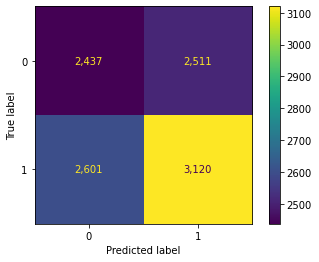

Holdout Data
-----------


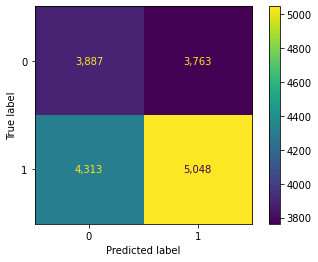

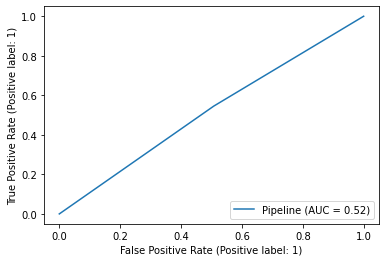

-----------------------------------
Val data
-----------
Jun 13 2021 joey lucchesi New York Mets 1.0 0
Jun 14 2021 andrelton simmons Minnesota Twins 1.0 0
Jun 15 2021 mike tauchman San Francisco Giants 1.0 0
Jun 16 2021 tony kemp Oakland Athletics 1.0 1
Jun 17 2021 jose altuve Houston Astros 1.0 1
Jun 18 2021 maikel franco Baltimore Orioles 1.0 1
Jun 19 2021 yu chang Cleveland Indians 1.0 0
Jun 20 2021 dinelson lamet San Diego Padres 1.0 0
Jun 21 2021 manny machado San Diego Padres 1.0 1
Jun 22 2021 webster rivas San Diego Padres 1.0 0
Jun 23 2021 michael taylor Kansas City Royals 1.0 1
Jun 24 2021 matt chapman Oakland Athletics 1.0 1
Jun 25 2021 michael taylor Kansas City Royals 1.0 1
Jun 26 2021 rougned odor New York Yankees 1.0 0
Jun 27 2021 yonathan daza Colorado Rockies 1.0 0
Jun 28 2021 jonathan india Cincinnati Reds 1.0 1
Jun 29 2021 nelson cruz Minnesota Twins 1.0 1
Jun 30 2021 ian happ Chicago Cubs 1.0 0
Aug 31 2021 jesus aguilar Miami Marlins 1.0 1
Longest streak in set (39 d

In [392]:
start = datetime.now()
dt = DecisionTreeClassifier()

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree', dt)
])

run_model(clf, X_train, X_val, y_train, y_val, test_df)

# Model 2: Logistic Regression

Model should take between 0 and 1 minutes to run and finish by 13:46
Train Scores
------------
Accuracy: 0.545189593815192
F1 Score: 0.7056604522802629
ROC-AUC: 0.4932457611606077
Precision: 0.545189593815192
-----------------------------------
Val Scores
-----------
Accuracy: 0.536226450463961
F1 Score: 0.6981086028065894
ROC-AUC: 0.49574932558528284
Precision: 0.536226450463961
-----------------------------------
Holdout Scores
-----------
Accuracy: 0.5502909881841161
F1 Score: 0.7099196117093887
ROC-AUC: 0.49844882780944155
Precision: 0.5502909881841161

Val Data
-----------


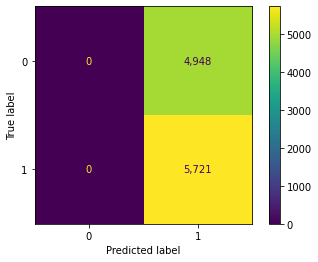

Holdout Data
-----------


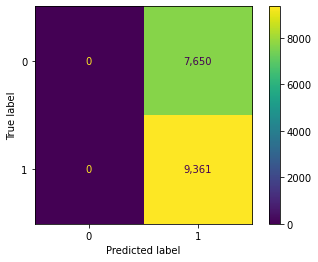

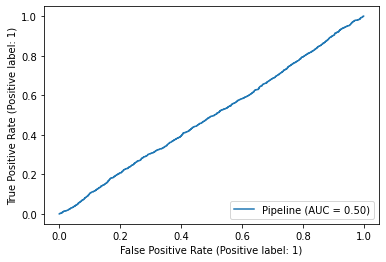

-----------------------------------
Val data
-----------
Jun 13 2021 andrew vaughn Chicago White Sox 0.5508893781187301 0
Jun 14 2021 andrew vaughn Chicago White Sox 0.550889377019408 0
Jun 15 2021 andrew vaughn Chicago White Sox 0.5508893234759759 1
Jun 16 2021 andrew vaughn Chicago White Sox 0.5508893614513677 1
Jun 17 2021 andrew vaughn Chicago White Sox 0.5508893892724409 0
Jun 18 2021 andrew vaughn Chicago White Sox 0.5508893227671954 1
Jun 19 2021 andrew vaughn Chicago White Sox 0.5508893342469001 1
Jun 20 2021 andrew vaughn Chicago White Sox 0.5508893805126535 0
Jun 21 2021 ryan jeffers Minnesota Twins 0.5506707842708142 0
Jun 22 2021 andrew vaughn Chicago White Sox 0.5508892158205265 0
Jun 23 2021 andrew vaughn Chicago White Sox 0.5508892439495838 0
Jun 24 2021 wander franco Tampa Bay Rays 0.5504322435503346 0
Jun 25 2021 andrew vaughn Chicago White Sox 0.5508893088862357 1
Jun 26 2021 wander franco Tampa Bay Rays 0.5504322210692817 0
Jun 27 2021 andrew vaughn Chicago White Sox

In [393]:
start = datetime.now()

logreg = LogisticRegression(solver='sag')

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logreg', logreg)
])

run_model(clf, X_train, X_val, y_train, y_val, test_df)

# Model 3: SVC

Model should take between 0 and 2 minutes to run and finish by 13:47
Train Scores
------------
Accuracy: 0.545189593815192
F1 Score: 0.7056604522802629
ROC-AUC: 0.5
Precision: 0.545189593815192
-----------------------------------
Val Scores
-----------
Accuracy: 0.536226450463961
F1 Score: 0.6981086028065894
ROC-AUC: 0.5
Precision: 0.536226450463961
-----------------------------------
Holdout Scores
-----------
Accuracy: 0.5502909881841161
F1 Score: 0.7099196117093887
ROC-AUC: 0.5
Precision: 0.5502909881841161

Val Data
-----------


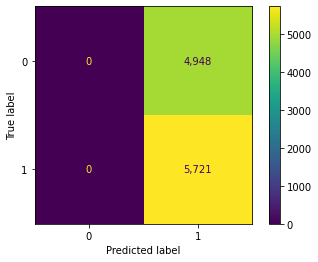

Holdout Data
-----------


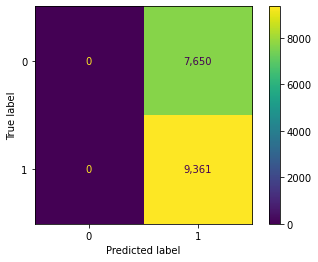

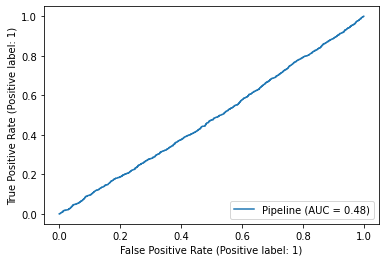

-----------------------------------
Val data
-----------
Jun 13 2021 joey lucchesi New York Mets 1 0
Jun 14 2021 andrelton simmons Minnesota Twins 1 0
Jun 15 2021 tommy pham San Diego Padres 1 1
Jun 16 2021 chris taylor Los Angeles Dodgers 1 0
Jun 17 2021 jose altuve Houston Astros 1 1
Jun 18 2021 jace peterson Milwaukee Brewers 1 0
Jun 19 2021 seth brown Oakland Athletics 1 1
Jun 20 2021 martin maldonado Houston Astros 1 0
Jun 21 2021 manny machado San Diego Padres 1 1
Jun 22 2021 gregory polanco Pittsburgh Pirates 1 1
Jun 23 2021 erik gonzalez Pittsburgh Pirates 1 0
Jun 24 2021 whit merrifield Kansas City Royals 1 1
Jun 25 2021 michael taylor Kansas City Royals 1 1
Jun 26 2021 rougned odor New York Yankees 1 0
Jun 27 2021 yasmani grandal Chicago White Sox 1 1
Jun 28 2021 david peralta Arizona Diamondbacks 1 0
Jun 29 2021 emmanuel rivera Kansas City Royals 1 0
Jun 30 2021 ian happ Chicago Cubs 1 0
Aug 31 2021 jorge alfaro Miami Marlins 1 0
Longest streak in set (39 days):  3
Total cor

In [394]:
start = datetime.now()

svc = SVC()


clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', svc)
])


run_model(clf, X_train, X_val, y_train, y_val, test_df)

# Model 3.5: LinearSVC

Model should take between 0 and 1 minutes to run and finish by 13:56
Train Scores
------------
Accuracy: 0.545189593815192
F1 Score: 0.7056604522802629
ROC-AUC: 0.5
Precision: 0.545189593815192
-----------------------------------
Val Scores
-----------
Accuracy: 0.536226450463961
F1 Score: 0.6981086028065894
ROC-AUC: 0.5
Precision: 0.536226450463961
-----------------------------------
Holdout Scores
-----------
Accuracy: 0.5502909881841161
F1 Score: 0.7099196117093887
ROC-AUC: 0.5
Precision: 0.5502909881841161

Val Data
-----------


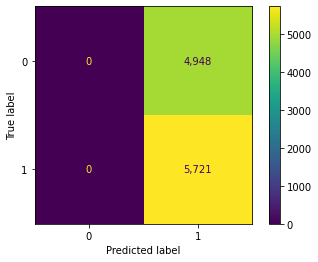

Holdout Data
-----------


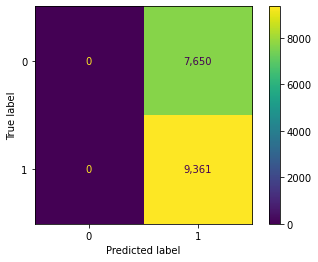

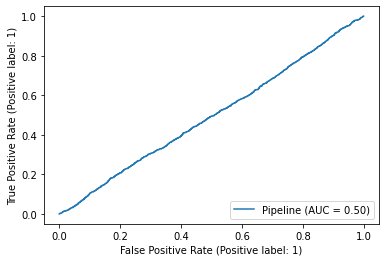

-----------------------------------
Val data
-----------
Jun 13 2021 joey lucchesi New York Mets 1 0
Jun 14 2021 andrelton simmons Minnesota Twins 1 0
Jun 15 2021 tommy pham San Diego Padres 1 1
Jun 16 2021 chris taylor Los Angeles Dodgers 1 0
Jun 17 2021 jose altuve Houston Astros 1 1
Jun 18 2021 jace peterson Milwaukee Brewers 1 0
Jun 19 2021 seth brown Oakland Athletics 1 1
Jun 20 2021 martin maldonado Houston Astros 1 0
Jun 21 2021 manny machado San Diego Padres 1 1
Jun 22 2021 gregory polanco Pittsburgh Pirates 1 1
Jun 23 2021 erik gonzalez Pittsburgh Pirates 1 0
Jun 24 2021 whit merrifield Kansas City Royals 1 1
Jun 25 2021 michael taylor Kansas City Royals 1 1
Jun 26 2021 rougned odor New York Yankees 1 0
Jun 27 2021 yasmani grandal Chicago White Sox 1 1
Jun 28 2021 david peralta Arizona Diamondbacks 1 0
Jun 29 2021 emmanuel rivera Kansas City Royals 1 0
Jun 30 2021 ian happ Chicago Cubs 1 0
Aug 31 2021 jorge alfaro Miami Marlins 1 0
Longest streak in set (39 days):  3
Total cor

In [395]:
start = datetime.now()

Linearsvc = LinearSVC()


clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linearsvc', Linearsvc)
])


run_model(clf, X_train, X_val, y_train, y_val, test_df)

# Model 4: KNN

Model should take between 0 and 3 minutes to run and finish by 13:58
Train Scores
------------
Accuracy: 0.7172659221990428
F1 Score: 0.7503115686805744
ROC-AUC: 0.7849703141987301
Precision: 0.7234965254193009
-----------------------------------
Val Scores
-----------
Accuracy: 0.568094479332646
F1 Score: 0.608629182945473
ROC-AUC: 0.5866534595698074
Precision: 0.5919378820419626
-----------------------------------
Holdout Scores
-----------
Accuracy: 0.5566986067838458
F1 Score: 0.5972763684913217
ROC-AUC: 0.5680130258135373
Precision: 0.5971806920119607

Val Data
-----------


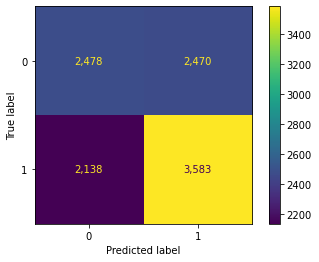

Holdout Data
-----------


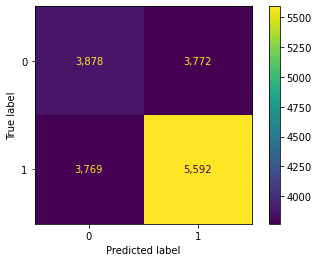

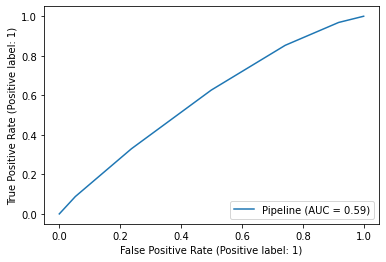

-----------------------------------
Val data
-----------
Jun 13 2021 andrew benintendi Kansas City Royals 1.0 1
Jun 14 2021 raimel tapia Colorado Rockies 1.0 1
Jun 15 2021 tommy pham San Diego Padres 1.0 1
Jun 16 2021 adam frazier Pittsburgh Pirates 1.0 0
Jun 17 2021 michael brantley Houston Astros 1.0 1
Jun 18 2021 jake cronenworth San Diego Padres 1.0 1
Jun 19 2021 jose altuve Houston Astros 1.0 1
Jun 20 2021 ji-man choi Tampa Bay Rays 1.0 1
Jun 21 2021 isiah kiner-falefa Texas Rangers 1.0 1
Jun 22 2021 marcus semien Toronto Blue Jays 1.0 0
Jun 23 2021 aj pollock Los Angeles Dodgers 1.0 0
Jun 24 2021 nick castellanos Cincinnati Reds 1.0 1
Jun 25 2021 ji-man choi Tampa Bay Rays 1.0 0
Jun 26 2021 randy arozarena Tampa Bay Rays 1.0 1
Jun 27 2021 vladimir guerrero Toronto Blue Jays 1.0 1
Jun 28 2021 jose ramirez Cleveland Indians 1.0 1
Jun 29 2021 tony santillan Cincinnati Reds 1.0 0
Jun 30 2021 nick castellanos Cincinnati Reds 1.0 1
Aug 31 2021 jorge alfaro Miami Marlins 1.0 0
Longest s

In [396]:
start = datetime.now()

knn = KNeighborsClassifier(n_jobs=-1)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])


run_model(clf, X_train, X_val, y_train, y_val, test_df)

# Model 5: Random Forest

Model should take between 0 and 2 minutes to run and finish by 14:00
Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0
-----------------------------------
Val Scores
-----------
Accuracy: 0.5845908707470241
F1 Score: 0.6360650353095747
ROC-AUC: 0.6149115810547506
Precision: 0.5998141551804244
-----------------------------------
Holdout Scores
-----------
Accuracy: 0.5910293339603786
F1 Score: 0.6439428834638414
ROC-AUC: 0.614022864994732
Precision: 0.6180978581253684

Val Data
-----------


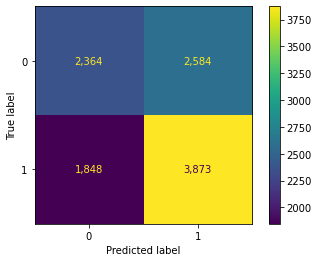

Holdout Data
-----------


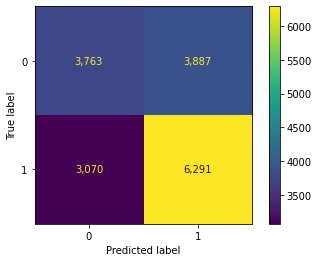

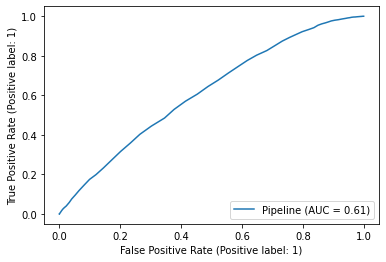

-----------------------------------
Val data
-----------
Jun 13 2021 nick castellanos Cincinnati Reds 0.75 1
Jun 14 2021 trea turner Washington Nationals 0.77 1
Jun 15 2021 jose altuve Houston Astros 0.77 1
Jun 16 2021 jared walsh Los Angeles Angels 0.77 0
Jun 17 2021 gio urshela New York Yankees 0.79 1
Jun 18 2021 lourdes gurriel Toronto Blue Jays 0.79 1
Jun 19 2021 trevor story Colorado Rockies 0.76 1
Jun 20 2021 dj lemahieu New York Yankees 0.77 1
Jun 21 2021 yuli gurriel Houston Astros 0.69 1
Jun 22 2021 jose altuve Houston Astros 0.79 0
Jun 23 2021 yordan álvarez Houston Astros 0.78 1
Jun 24 2021 adam frazier Pittsburgh Pirates 0.75 1
Jun 25 2021 michael conforto New York Mets 0.75 0
Jun 26 2021 dansby swanson Atlanta Braves 0.76 1
Jun 27 2021 trea turner Washington Nationals 0.75 1
Jun 28 2021 jose altuve Houston Astros 0.8 0
Jun 29 2021 dj lemahieu New York Yankees 0.81 1
Jun 30 2021 nolan arenado St. Louis Cardinals 0.74 0
Aug 31 2021 francisco lindor New York Mets 0.61 0
Longe

In [397]:
start = datetime.now()

rfc = RandomForestClassifier(n_jobs=-1)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfc', rfc)
])

run_model(clf, X_train, X_val, y_train, y_val, test_df)

# Model 6: AdaBoost


Model should take between 0 and 3 minutes to run and finish by 14:02
Train Scores
------------
Accuracy: 0.603386918640324
F1 Score: 0.6753390256152687
ROC-AUC: 0.6390422807379968
Precision: 0.6098235747652955
-----------------------------------
Val Scores
-----------
Accuracy: 0.6028681225981817
F1 Score: 0.670554389238784
ROC-AUC: 0.6264644348064832
Precision: 0.6039215686274509
-----------------------------------
Holdout Scores
-----------
Accuracy: 0.6017870789489154
F1 Score: 0.6732587304649816
ROC-AUC: 0.617326280011702
Precision: 0.6137542872218802

Val Data
-----------


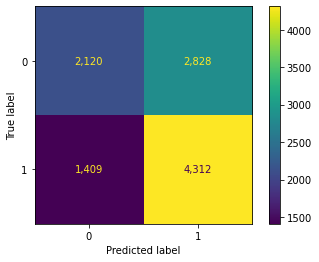

Holdout Data
-----------


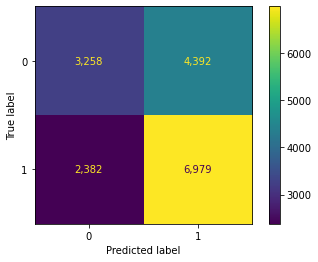

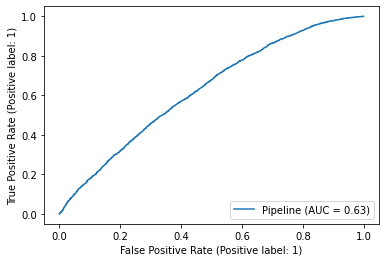

-----------------------------------
Val data
-----------
Jun 13 2021 nick castellanos Cincinnati Reds 0.5067937307595812 1
Jun 14 2021 mookie betts Los Angeles Dodgers 0.5092904805965855 0
Jun 15 2021 mookie betts Los Angeles Dodgers 0.5074811476323988 1
Jun 16 2021 mookie betts Los Angeles Dodgers 0.5064215854445432 0
Jun 17 2021 tommy edman St. Louis Cardinals 0.5062208773514766 0
Jun 18 2021 bo bichette Toronto Blue Jays 0.5069363422523229 0
Jun 19 2021 trea turner Washington Nationals 0.5065350362716549 1
Jun 20 2021 trevor story Colorado Rockies 0.5079415308983691 1
Jun 21 2021 mookie betts Los Angeles Dodgers 0.5050399875289784 1
Jun 22 2021 tommy edman St. Louis Cardinals 0.5059969082345736 1
Jun 23 2021 wander franco Tampa Bay Rays 0.5071367957809373 0
Jun 24 2021 trea turner Washington Nationals 0.5079988594933474 1
Jun 25 2021 vladimir guerrero Toronto Blue Jays 0.5073773301527451 1
Jun 26 2021 xander bogaerts Boston Red Sox 0.5069783022801898 1
Jun 27 2021 tim anderson Chica

In [398]:
start = datetime.now()

ada = AdaBoostClassifier(random_state=42)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ada', ada)
])

run_model(clf, X_train, X_val, y_train, y_val, test_df)

# Model 7: GradientBoost


Model should take between 0 and 1 minutes to run and finish by 14:00
Train Scores
------------
Accuracy: 0.6218861209964412
F1 Score: 0.693659433798126
ROC-AUC: 0.6667921523242625
Precision: 0.6212269610898407
-----------------------------------
Val Scores
-----------
Accuracy: 0.6002436966913488
F1 Score: 0.6574022009799985
ROC-AUC: 0.6312111260376576
Precision: 0.60820451843044
-----------------------------------
Holdout Scores
-----------
Accuracy: 0.6019046499323967
F1 Score: 0.6617044659806175
ROC-AUC: 0.6252437138370642
Precision: 0.62146945669513

Val Data
-----------


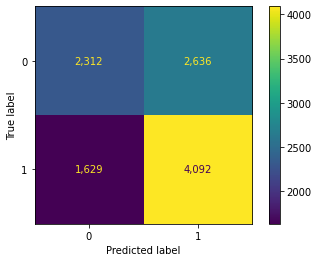

Holdout Data
-----------


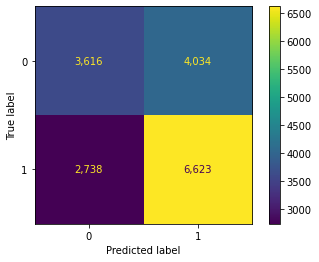

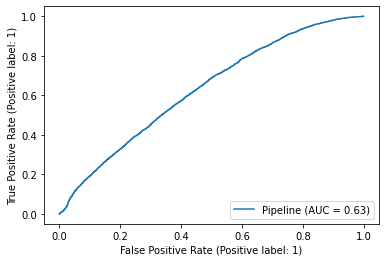

-----------------------------------
Val data
-----------
Jun 13 2021 nick castellanos Cincinnati Reds 0.7767899295201779 1
Jun 14 2021 mookie betts Los Angeles Dodgers 0.7904258475205086 0
Jun 15 2021 jose altuve Houston Astros 0.8125349507604461 1
Jun 16 2021 ke'bryan hayes Pittsburgh Pirates 0.8124568563401151 1
Jun 17 2021 dj lemahieu New York Yankees 0.7544368669692806 1
Jun 18 2021 marcus semien Toronto Blue Jays 0.774467279483299 0
Jun 19 2021 trea turner Washington Nationals 0.8025300660751343 1
Jun 20 2021 trevor story Colorado Rockies 0.8006012881456949 1
Jun 21 2021 jose altuve Houston Astros 0.7406456273443305 1
Jun 22 2021 jose altuve Houston Astros 0.729674953043902 0
Jun 23 2021 jose altuve Houston Astros 0.8117454488225813 1
Jun 24 2021 trea turner Washington Nationals 0.824163331939769 1
Jun 25 2021 marcus semien Toronto Blue Jays 0.8020074758897517 1
Jun 26 2021 starling marte Miami Marlins 0.778869899383456 0
Jun 27 2021 tim anderson Chicago White Sox 0.79698130608275

In [399]:
start = datetime.now()

gbm = GradientBoostingClassifier()
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gbm', gbm)
])

run_model(clf, X_train, X_val, y_train, y_val, test_df)

# Model 8: XGBoost


[13:59:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model should take between 0 and 2 minutes to run and finish by 14:01
[13:59:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Scores
------------
Accuracy: 0.8123696159037919
F1 Score: 0.8384404057480981
ROC-AUC: 0.9007336184357049
Precision: 0.7901418969380134
-----------------------------------
Val Scores
-----------
Accuracy: 0.5667822663792296
F1 Score: 0.5856195086964318
ROC-AUC: 0.5951194114296462
Precision: 0.60114117430

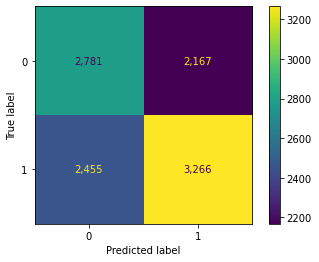

Holdout Data
-----------


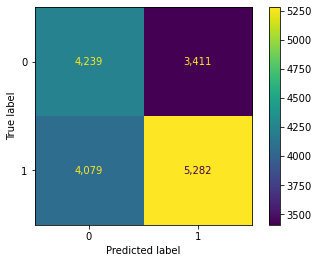

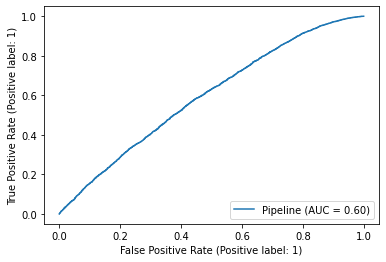

-----------------------------------
Val data
-----------
Jun 13 2021 teoscar hernandez Toronto Blue Jays 0.87831545 1
Jun 14 2021 nick castellanos Cincinnati Reds 0.94267017 1
Jun 15 2021 ke'bryan hayes Pittsburgh Pirates 0.89621955 0
Jun 16 2021 ke'bryan hayes Pittsburgh Pirates 0.9778175 1
Jun 17 2021 tim anderson Chicago White Sox 0.8763426 0
Jun 18 2021 vladimir guerrero Toronto Blue Jays 0.91736096 0
Jun 19 2021 vladimir guerrero Toronto Blue Jays 0.92017984 1
Jun 20 2021 bo bichette Toronto Blue Jays 0.9172742 1
Jun 21 2021 francisco lindor New York Mets 0.86436546 0
Jun 22 2021 yandy díaz Tampa Bay Rays 0.88619643 1
Jun 23 2021 tim anderson Chicago White Sox 0.90841484 1
Jun 24 2021 vladimir guerrero Toronto Blue Jays 0.9109266 1
Jun 25 2021 yandy díaz Tampa Bay Rays 0.92029744 1
Jun 26 2021 giancarlo stanton New York Yankees 0.9169886 1
Jun 27 2021 teoscar hernandez Toronto Blue Jays 0.9496941 1
Jun 28 2021 nick castellanos Cincinnati Reds 0.90609074 1
Jun 29 2021 marcus semien

In [400]:
start = datetime.now()

xbg = xgb.XGBClassifier(random_state=42)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xbg', xbg)
])

run_model(clf, X_train, X_val, y_train, y_val, test_df)

# Model 9: Random Forest with Grid Search


[13:59:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model should take between 0 and 1 minutes to run and finish by 14:01
[13:59:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Scores
------------
Accuracy: 0.8123696159037919
F1 Score: 0.8384404057480981
ROC-AUC: 0.9007336184357049
Precision: 0.7901418969380134
-----------------------------------
Val Scores
-----------
Accuracy: 0.5667822663792296
F1 Score: 0.5856195086964318
ROC-AUC: 0.5951194114296462
Precision: 0.60114117430

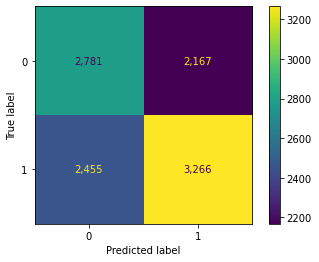

Holdout Data
-----------


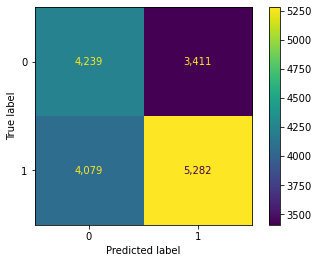

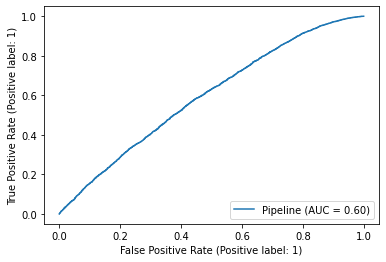

-----------------------------------
Val data
-----------
Jun 13 2021 teoscar hernandez Toronto Blue Jays 0.87831545 1
Jun 14 2021 nick castellanos Cincinnati Reds 0.94267017 1
Jun 15 2021 ke'bryan hayes Pittsburgh Pirates 0.89621955 0
Jun 16 2021 ke'bryan hayes Pittsburgh Pirates 0.9778175 1
Jun 17 2021 tim anderson Chicago White Sox 0.8763426 0
Jun 18 2021 vladimir guerrero Toronto Blue Jays 0.91736096 0
Jun 19 2021 vladimir guerrero Toronto Blue Jays 0.92017984 1
Jun 20 2021 bo bichette Toronto Blue Jays 0.9172742 1
Jun 21 2021 francisco lindor New York Mets 0.86436546 0
Jun 22 2021 yandy díaz Tampa Bay Rays 0.88619643 1
Jun 23 2021 tim anderson Chicago White Sox 0.90841484 1
Jun 24 2021 vladimir guerrero Toronto Blue Jays 0.9109266 1
Jun 25 2021 yandy díaz Tampa Bay Rays 0.92029744 1
Jun 26 2021 giancarlo stanton New York Yankees 0.9169886 1
Jun 27 2021 teoscar hernandez Toronto Blue Jays 0.9496941 1
Jun 28 2021 nick castellanos Cincinnati Reds 0.90609074 1
Jun 29 2021 marcus semien

In [401]:
start = datetime.now()

parameters = {
    'min_samples_split': [3, 5, 100], 
    'n_estimators' : [100, 300],
        'max_depth': [3, 5, 15, 25],

}

run_model(clf, X_train, X_val, y_train, y_val, test_df)

# Daily Guess

In [462]:
def time_date_weather_data(game_pk_df):
    venue_coords = pd.read_csv('Parks.csv')
    data_collection = {}

    game_pk_df['coordinates'] = game_pk_df['venue_name'].apply(lambda x: ','.join([str(venue_coords[venue_coords['NAME'] == x]['Latitude'].iloc[0]), str(venue_coords[venue_coords['NAME'] == x]['Longitude'].iloc[0])]))
    game_pk_df['alt'] = game_pk_df['venue_name'].apply(lambda x: venue_coords[venue_coords['NAME'] == x]['Altitude'].iloc[0])


    game_pk_df = game_pk_df.sort_values(['game_datetime'])



    game_pk_df['local_datetime'] = game_pk_df.apply(lambda row: convert_UTC_to_local(row), axis=1)
    game_pk_df['local_datetime'] = game_pk_df['local_datetime'].apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S"))


    from api_keys import visual_crossing
    import requests

    weather_df = pd.DataFrame()
    for index, row in game_pk_df.iterrows():
#         check if key is past or future
        if datetime.strptime(row['game_datetime'], "%Y-%m-%dT%H:%M:%SZ") > datetime.utcnow():
            URL = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/forecast?locations={row["coordinates"]}&aggregateHours=1&unitGroup=us&forecastDays=1&shortColumnNames=true&contentType=json&key={visual_crossing}'

        else:
            URL = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?&aggregateHours=1&startDateTime={row["local_datetime"]}&endDateTime={row["local_datetime"]}&unitGroup=us&contentType=json&location={row["coordinates"]}&key={visual_crossing}'
        global api_counter
        if api_counter >= 1000:
            print('Prepreprocessing will continue at ' + (datetime.now()+timedelta(seconds = 86400)).strftime('%H:%M:%S'))
            sleep(86400)
            api_counter = 0
            api_counter += 1
            response = requests.get(URL)
        try:
            data = response.json()
            if (
                data['locations'][row['coordinates']]['values'][0]['temp']
                is None
            ):
                URL = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/forecast?locations={row["coordinates"]}&aggregateHours=1&unitGroup=us&forecastDays=1&shortColumnNames=true&contentType=json&key={visual_crossing}'
                api_counter += 1
                response = requests.get(URL)
                data = response.json()

            if len(data['locations'][row['coordinates']]['values']) > 1:
                for forecast in data['locations'][row['coordinates']]['values']:

                    if forecast['datetimeStr'][:13] == row['local_datetime'][:13]:
                        values = forecast
                        values['datetimeStr'] = row['local_datetime']


            else:
                values = data['locations'][row['coordinates']]['values'][0]
                values['datetimeStr'] = row['local_datetime']
            data_collection[URL] = data
            weather_df = weather_df.append({**{'coordinates': row['coordinates']}, **values}, ignore_index=True)

        except:
            raise IndexError(index, row, response, response.json())
    weather_df = weather_df.rename(columns={'datetimeStr': 'local_datetime'})


    return pd.merge(
        game_pk_df,
        weather_df,
        how="left",
        on=None,
        left_on=['local_datetime', 'coordinates'],
        right_on=['local_datetime', 'coordinates'],
        left_index=False,
        right_index=False,
        sort=False,
        suffixes=("_gpk", "_wdf"),
        copy=True,
        indicator=False,
        validate=None,
    )

In [463]:
def lookup_mlb():
    """Get list of MLB team IDs for the purposes of pulling active rosters"""
    params = {
        "activeStatus": 'Y',
        "season": 2021,
        "sportIds": 1,
        "fields": "teams,id,name,league",
    }

    r= statsapi.get('teams', params)

    return {
        team['name']: team['id']
        for team in r['teams']
        if team['league']['id'] in [103, 104]
    }

def roster(teamId, rosterType=None, season=datetime.now().year, date=None):
    """Get the roster for a given team."""
    if not rosterType:
        rosterType = "active"

    params = {"rosterType": rosterType, "season": season, "teamId": teamId}
    if date:
        params.update({"date": date})

    r = statsapi.get("team_roster", params)

    return [x["person"]["id"] for x in r["roster"]]

def lookup_team(lookup_value, activeStatus="Y", season=datetime.now().year, sportIds=1):
    """Get a info about a team or teams based on the team name, city, abbreviation, or file code."""
    params = {
        "activeStatus": activeStatus,
        "season": season,
        "sportIds": sportIds,
        "fields": "teams,id,name,teamCode,fileCode,teamName,locationName,shortName,league",
    }
    r = statsapi.get("teams", params)

    teams = []
    for team in r["teams"]:
        for v in team.values():
            if str(lookup_value).lower() in str(v).lower():
                teams.append(team)
                break

    return (teams)

In [474]:
# to be run daily
def daily_guess():
    '''Implementing a daily recommendation engine based on the LinearSCV model'''
    # get game data, then weather data, then derive_pitcher data, then derive_batter data

    todays_games = pd.DataFrame()


    for game in statsapi.schedule():
    #     grab 'away_probable_pitcher','home_probable_pitcher','away_name',
    #     'home_name','doubleheader','game_num','venue_name','game_datetime'

    #     df['local_datetime'] = pd.to_datetime(df['local_datetime'])
    #     df['local_date'] = df['local_datetime'].apply(lambda x: x.toordinal())
    #     df['local_datetime'] = df['local_datetime'].apply(lambda x: x.timestamp())

        row = {
            'game_id': game['game_id'],
            'away_probable_pitcher': game['away_probable_pitcher'],
            'home_probable_pitcher': game['home_probable_pitcher'],
            'away_name': game['away_name'],
            'home_name': game['home_name'],
            'doubleheader': game['doubleheader'],
            'game_num': game['game_num'],
            'venue_name': game['venue_name'],
            'game_datetime': game['game_datetime']
        }

        todays_games = todays_games.append(row, ignore_index=True)

    todays_games = todays_games.replace('', np.nan)    
    global games_and_weather
    games_and_weather = time_date_weather_data(todays_games)
# def daily_guess(games_and_weather):
    for i in ['home_probable_pitcher', 'away_probable_pitcher']:
        games_and_weather[i] = games_and_weather[i].fillna('Unknown')
    away_pitchers = games_and_weather['away_probable_pitcher']
    home_pitchers = games_and_weather['home_probable_pitcher']
    global pitchers_stats
    pitchers_stats = pd.DataFrame()

    history = pd.concat([
    set_types(pd.read_csv('data/2019_statcast_pbp.csv'), type_dict),
    set_types(pd.read_csv('data/2020_statcast_pbp.csv'), type_dict),
    set_types(pd.read_csv('data/2021_statcast_pbp.csv'), type_dict)
    ], ignore_index=True)
    
    sample = pd.read_csv('df_final', index_col=0)
    pitchers_stats_cols = ['pitch_hand', 'games_played_last_2_years_pitcher',
       'avg_innings_per_appearance', 'avg_PAs_per_appearance_pitcher',
       'avg_hits_per_inning', 'H/PA_pitcher', 'against_lefties_H/PA',
       'against_righties_H/PA', 'probable_pitcher']
    
    average_pitcher = {}

    for col in pitchers_stats_cols:
        if col == 'probable_pitcher':
            col_val = 'Unknown'
        else:
            try:
                col_val = sample[col].mean()
            except TypeError:
                col_val = list(sample[col].value_counts().index)[0]
        average_pitcher[col] = col_val
    
    
    for a in away_pitchers:
        print(a)
        if a == 'Unknown':
            pitchers_stats = pitchers_stats.append(pd.Series(average_pitcher), ignore_index=True)
        else:
            pitchers_stats = pitchers_stats.append({**derived_cumulative_stats(a, 'derive_pitcher', history, end_date=(datetime.now()-timedelta(seconds=86400))), **{'probable_pitcher': a}}, ignore_index=True)

    for h in home_pitchers:
        print(h)
        if h == 'Unknown':
            pitchers_stats = pitchers_stats.append(pd.Series(average_pitcher), ignore_index=True)
        else:
            pitchers_stats = pitchers_stats.append({**derived_cumulative_stats(h, 'derive_pitcher', history, end_date=(datetime.now()-timedelta(seconds=86400))), **{'probable_pitcher': h}}, ignore_index=True)

    game_columns = ['away_name',
                     'home_name',
                     'doubleheader',
                     'game_num',
                     'venue_name',
                     'local_datetime',
                     'coordinates',
                     'cloudcover',
                     'conditions',
                     'dew',
                     'heatindex',
                     'humidity',
                     'precip',
                     'sealevelpressure',
                     'snowdepth',
                     'temp',
                     'visibility',
                     'wdir',
                     'wgust',
                     'windchill',
                     'wspd',
                     'alt'
     ]
            
    batting_stats = pd.DataFrame()
    for index, game in games_and_weather.iterrows():
        print(game[['away_name', 'home_name']])
    #     home batters, away derive_pitcher
        batting_team_id = lookup_mlb()[game['home_name']]
        batting_roster = roster(batting_team_id)
        for b in batting_roster:
            start = datetime.now()
            
            batter_righty = 1 if statsapi.player_stat_data(b)['bat_side'] == 'Right' else 0
            home = 1 if game['home_name'] == statsapi.player_stat_data(b)['current_team'] else 0
            batting_stats = batting_stats.append({**derived_cumulative_stats(b, 'derive_batter', history, end_date=(datetime.now()-timedelta(seconds=86400))),**{'derive_batter': b, 'game_year': datetime.now().year, 'batter_righty': batter_righty, 'home': home}, **pitchers_stats[pitchers_stats['probable_pitcher'] == game['away_probable_pitcher']].iloc[0], **game[game_columns]}, ignore_index=True)
            print(datetime.now()-start)
        #     away batters, home derive_pitcher
        batting_team_id = lookup_mlb()[game['away_name']]
        batting_roster = roster(batting_team_id)
        for b in batting_roster:
            batter_righty = 1 if statsapi.player_stat_data(b)['bat_side'] == 'Right' else 0
            home = 1 if game['home_name'] == statsapi.player_stat_data(b)['current_team'] else 0
            batting_stats = batting_stats.append({**derived_cumulative_stats(b, 'derive_batter', history, end_date=(datetime.now()-timedelta(seconds=86400))), **{'derive_batter': b, 'game_year': datetime.now().year, 'batter_righty': batter_righty, 'home': home}, **pitchers_stats[pitchers_stats['probable_pitcher'] == game['home_probable_pitcher']].iloc[0], **game[game_columns]}, ignore_index=True)
            
    batting_stats['covid_doubleheader'] = batting_stats.apply(
    lambda row: 1 if row['game_year'] in [2020, 2021] and row['doubleheader'] == 'Y' else 0, axis=1)
    
    american_league_teams = np.array(['Boston Red Sox', 'Houston Astros', 'Chicago White Sox', 'Tampa Bay Rays', 'Oakland Athletics', 'Seattle Mariners', 'New York Yankees', 'Toronto Blue Jays', 'Los Angeles Angels', 'Cleveland Indians', 'Detroit Tigers', 'Kansas City Royals', 'Minnesota Twins', 'Texas Rangers', 'Baltimore Orioles'])
    
    batting_stats['designated_hitter'] = batting_stats.apply(
    lambda row: 1 if row['home_name'] in american_league_teams or row['game_year'] == 2020 else 0, axis=1)
    
        #     transforms date and datetime columns into easily comparable numbers
    batting_stats['local_datetime'] = pd.to_datetime(batting_stats['local_datetime'])
    batting_stats['local_date'] = batting_stats['local_datetime'].apply(lambda x: x.toordinal())
    batting_stats['local_datetime'] = batting_stats['local_datetime'].apply(lambda x: x.timestamp())
    
    return(batting_stats)
# TODO
# RUN batting_stats through predictors

In [475]:
def run_model_todays_data(batting_stats):
    recommendations = []
    for model in os.listdir('models/'):
        with open('models/' + model, 'rb') as f:
            clf = pickle.load(f)
            try:
                todays_odds = pd.Series(clf.predict_proba(batting_stats[X_train.columns])[:, 1], name='odds')
            except AttributeError:
                todays_odds = pd.Series(clf.predict(batting_stats[X_train.columns]), name='odds')

            batting_stats_temp = batting_stats.reset_index(drop=True)
            batting_stats_temp = batting_stats.assign(odds=todays_odds)
            
#             print('-----------------------------------')

#             print(model)
#             print('-----------')

            recommendations.append(streak_checker(batting_stats_temp, output=True, today=True))
#             print(recommendations)
#             print('Holdout data')
#             print('-----------')

#             streak_checker(holdout, output=True)
#             ('-----------------------------------')
#             print('\n\nOdds multiplied by PA/G_batter\n\n')
            
#             print('-----------')

#             print('Val data')
#             print('-----------')
            recommendations.append(streak_checker(batting_stats_temp, output=True, metric=['PA/G_batter', 'odds'], combiner='multiply', today=True))
#             print('Holdout data')
#             print('-----------')
#             streak_checker(holdout, output=True, metric=['PA/G_batter', 'odds'], combiner='multiply')
#             print('-----------')
#             ('-----------------------------------')
#             print('\n\nOdds added to PA/G_batter\n\n')
            
#             print('-----------')

#             print('Val data')
#             print('-----------')
            recommendations.append(streak_checker(batting_stats_temp, output=True, metric=['L/R_split', 'odds'], combiner='add', today=True))
#             print('-----------')
#             print('Holdout data')
#             print('-----------')
#             streak_checker(holdout, output=True, metric=['L/R_split', 'odds'], combiner='add')
    return(recommendations)

In [476]:
start = datetime.now()

batting_stats = daily_guess()

datetime done
events done
stand done
pitcher done
inning done
datetime done
events done
stand done
pitcher done
inning done
datetime done
events done
stand done
pitcher done
inning done
Triston McKenzie
2021-09-13 12:46:52.209895
Triston McKenzie
player filtered
Wade Miley
2021-09-13 12:46:53.036122
Wade Miley
player filtered
Freddy Peralta
2021-09-13 12:46:53.607314
Freddy Peralta
player filtered
Adrian Sampson
2021-09-13 12:46:54.112034
Adrian Sampson
player filtered
Jesus Luzardo
2021-09-13 12:46:54.566127
Jesus Luzardo
player filtered
Gerrit Cole
2021-09-13 12:46:55.065997
Gerrit Cole
player filtered
Drew Rasmussen
2021-09-13 12:46:55.601036
Drew Rasmussen
player filtered
Jake Woodford
2021-09-13 12:46:56.156067
Jake Woodford
player filtered
Jon Gray
2021-09-13 12:46:56.669261
Jon Gray
player filtered
Logan Allen
2021-09-13 12:46:57.152867
Logan Allen
player filtered
Zack Greinke
2021-09-13 12:46:57.668107
Zack Greinke
player filtered
Frankie Montas
2021-09-13 12:46:58.211849
Frank

2021-09-13 12:48:28.246272
666159
0:00:00.618723
2021-09-13 12:48:28.816762
605242
0:00:00.594198
2021-09-13 12:48:29.394046
408234
0:00:00.620696
2021-09-13 12:48:30.049362
592348
0:00:00.611616
2021-09-13 12:48:30.771007
543257
0:00:00.758077
2021-09-13 12:48:31.383177
669373
0:00:00.541238
2021-09-13 12:48:31.951713
641302
0:00:00.593817
2021-09-13 12:48:32.502751
622682
0:00:00.594415
2021-09-13 12:48:33.159685
650489
0:00:00.639316
2021-09-13 12:48:33.839228
503449
0:00:00.662691
2021-09-13 12:48:34.639414
676879
2021-09-13 12:48:35.223024
605288
2021-09-13 12:48:35.762177
541645
2021-09-13 12:48:36.391932
502202
2021-09-13 12:48:36.972216
605540
2021-09-13 12:48:37.578220
608718
2021-09-13 12:48:38.135008
592885
2021-09-13 12:48:38.808630
669203
2021-09-13 12:48:39.387174
596057
2021-09-13 12:48:39.961275
596129
2021-09-13 12:48:40.605504
642207
2021-09-13 12:48:41.257433
500871
2021-09-13 12:48:41.911872
641778
2021-09-13 12:48:42.463426
642547
2021-09-13 12:48:43.124009
519326


2021-09-13 12:50:25.646849
608336
2021-09-13 12:50:26.309618
656756
2021-09-13 12:50:26.857711
543309
2021-09-13 12:50:27.423930
476595
2021-09-13 12:50:28.019084
661563
2021-09-13 12:50:28.614149
572228
2021-09-13 12:50:29.270235
650633
2021-09-13 12:50:29.852599
641482
2021-09-13 12:50:30.401195
596059
2021-09-13 12:50:30.981348
642180
2021-09-13 12:50:31.624026
593974
away_name       Tampa Bay Rays
home_name    Toronto Blue Jays
Name: 6, dtype: object
2021-09-13 12:50:32.480039
643256
0:00:00.631935
2021-09-13 12:50:33.050575
672386
0:00:00.597306
2021-09-13 12:50:33.683089
666201
0:00:00.623243
2021-09-13 12:50:34.295884
666182
0:00:00.651250
2021-09-13 12:50:34.944620
591971
0:00:00.607283
2021-09-13 12:50:35.542646
572816
0:00:00.613027
2021-09-13 12:50:36.123614
643376
0:00:00.588925
2021-09-13 12:50:36.742620
543807
0:00:00.609051
2021-09-13 12:50:37.410040
547943
0:00:00.647421
2021-09-13 12:50:38.018497
571875
0:00:00.628452
2021-09-13 12:50:38.564457
502481
0:00:00.570919
20

0:00:00.570298
2021-09-13 12:52:23.539007
660896
0:00:00.591811
2021-09-13 12:52:24.112447
593871
0:00:00.613637
2021-09-13 12:52:24.737051
518626
0:00:00.611410
2021-09-13 12:52:25.332831
663558
0:00:00.553492
2021-09-13 12:52:25.894319
573668
0:00:00.575514
2021-09-13 12:52:26.441053
607457
0:00:00.528684
2021-09-13 12:52:26.988005
650333
0:00:00.610160
2021-09-13 12:52:27.614820
608652
0:00:00.555833
2021-09-13 12:52:28.195933
596146
0:00:00.644943
2021-09-13 12:52:28.831903
501381
0:00:00.579491
2021-09-13 12:52:29.700499
593934
0:00:00.943843
2021-09-13 12:52:30.378794
624503
0:00:00.647344
2021-09-13 12:52:31.051024
621248
0:00:00.653667
2021-09-13 12:52:31.690237
608701
0:00:00.642214
2021-09-13 12:52:32.366022
680777
0:00:00.694789
2021-09-13 12:52:33.116960
608648
0:00:00.705961
2021-09-13 12:52:33.735310
553902
0:00:00.653623
2021-09-13 12:52:34.633946
650644
2021-09-13 12:52:35.245009
622065
2021-09-13 12:52:35.814261
642708
2021-09-13 12:52:36.427236
665926
2021-09-13 12:52

2021-09-13 12:54:20.201834
665625
2021-09-13 12:54:20.794598
608686
2021-09-13 12:54:21.349508
642545
2021-09-13 12:54:21.942969
502593
2021-09-13 12:54:22.521659
676083
2021-09-13 12:54:23.075577
665120
2021-09-13 12:54:23.671988
623474
2021-09-13 12:54:24.256165
666176
2021-09-13 12:54:24.906015
650671
2021-09-13 12:54:25.515611
660761
2021-09-13 12:54:26.174653
501571
2021-09-13 12:54:26.782906
448855
2021-09-13 12:54:27.378042
642221
2021-09-13 12:54:27.959660
435559
2021-09-13 12:54:28.549638
667725
2021-09-13 12:54:29.129700
650859
2021-09-13 12:54:29.680222
545358
2021-09-13 12:54:30.485810
594577
2021-09-13 12:54:31.170611
661383
2021-09-13 12:54:31.742163
676050
2021-09-13 12:54:32.294427
594838
2021-09-13 12:54:32.868689
628452
2021-09-13 12:54:33.444847
572125
2021-09-13 12:54:33.993013
660271
2021-09-13 12:54:34.641666
518553
away_name        San Diego Padres
home_name    San Francisco Giants
Name: 13, dtype: object
2021-09-13 12:54:35.442843
543101
0:00:00.626747
2021-09-1

In [477]:
recommendations = run_model_todays_data(batting_stats)

from collections import Counter
Counter(recommendations)

Counter({'Alexander Wells - Baltimore Orioles': 1,
         'Marcus Semien - Toronto Blue Jays': 1,
         'Corey Seager - Los Angeles Dodgers': 9,
         'Skye Bolt - Oakland Athletics': 1,
         'Mookie Betts - Los Angeles Dodgers': 4,
         'Adam Wainwright - St. Louis Cardinals': 2,
         'Tayler Saucedo - Toronto Blue Jays': 1,
         'Cedric Mullins - Baltimore Orioles': 1,
         'Ryan Zimmerman - Washington Nationals': 1,
         'Jose Ramirez - Cleveland Indians': 1,
         'Andrew Heaney - New York Yankees': 1,
         'Tyler Wade - New York Yankees': 1,
         'Miguel Rojas - Miami Marlins': 1,
         'Antonio Senzatela - Colorado Rockies': 1,
         'Gio Urshela - New York Yankees': 1})

In [478]:
datetime.now() - start

datetime.timedelta(seconds=611, microseconds=58055)

## Daily Runtimes

9/11/21 - 564 seconds